In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats, ttest_ind

deals = pd.read_parquet('deals.parquet')
companies = pd.read_parquet('companies.parquet')
deals = deals.drop(['DealSynopsis', 'NativeCurrencyOfDeal', 'CompanyName', 'RowID', 'LastUpdated'], axis = 1)
deals_sorted = deals.sort_values(by=['CompanyID', 'DealNo'])

prelim_company = companies.drop(['FacebookProfileURL', 'TwitterProfileURL', 'LinkedInProfileURL',
       'PrimaryContactPBId', 'PrimaryContactFirstName',
       'PrimaryContactLastName', 'PrimaryContactMiddle',
       'PrimaryContactPrefix', 'PrimaryContactSuffix', 'PrimaryContact',
       'PrimaryContactTitle', 'RowID', 'CompanyAlsoKnownAs', 'CompanyFormerName',
       'CompanyLegalName', 'Description', 'Website', 'TotalRaisedNativeAmount', 'TotalRaisedNativeCurrency', 'DescriptionShort', 'FinancingStatusNote',
       'FinancingStatusNoteAsOfDate', 'Keywords', 'CompanyName', 'LastUpdated' 'ParentCompanyID'
       ], axis = 1)

df = pd.merge(deals, prelim_company, left_on= 'CompanyID', right_on= 'CompanyID', how = 'left')
df['ContingentPayout'].fillna(0, inplace= True)
df = df.sort_values(by=['CompanyID', 'DealNo'])

df.head()

/var/folders/h8/frp0f1bd0v32l04p93kbg3f00000gn/T/ipykernel_1339/243207172.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ContingentPayout'].fillna(0, inplace= True)


CompanyID  DealNo   DealDate AnnouncedDate  DealSize DealStatus  \
25191  100022-14       1 2014-10-30           NaT  0.400000  Completed   
24926  100022-14       2 2015-02-16           NaT  0.050000  Completed   
23958  100022-14       3 2016-02-10    2015-09-01  1.175000  Completed   
19779  100022-14       4 2018-12-26           NaT  2.999999  Completed   
17480  100022-14       5 2020-01-22    2019-06-15  5.099998  Completed   

      DealSizeStatus  PremoneyValuation  PostValuation PostValuationStatus  \
25191         Actual                NaN            NaN                None   
24926         Actual                NaN            NaN                None   
23958         Actual          19.999999      21.174999              Actual   
19779         Actual          35.000000      37.999999              Actual   
17480         Actual          40.000000      45.099998              Actual   

       ...           OwnershipStatus  OwnershipStatusDate  \
25191  ...  Privately Held (backing)           10/30/2014   
24926  ...  Privately Held (backing)           10/30/2014   
23958  ...  Privately Held (backing)           10/30/2014   
19779  ...  Privately Held (backing)           10/30/2014   
17480  ...  Privately Held (backing)           10/30/2014   

                   Universe Employees_y  EmployeeAsOfDate  Exchange Ticker  \
25191  M&A, Venture Capital        52.0        11/24/2022      None   None   
24926  M&A, Venture Capital        52.0        11/24/2022      None   None   
23958  M&A, Venture Capital        52.0        11/24/2022      None   None   
19779  M&A, Venture Capital        52.0        11/24/2022      None   None   
17480  M&A, Venture Capital        52.0        11/24/2022      None   None   

      YearFounded ParentCompany ParentCompanyID  
25191      2014.0          None            None  
24926      2014.0          None            None  
23958      2014.0          None            None  
19779      2014.0          None            None  
17480      2014.0          None            None  

[5 rows x 49 columns]

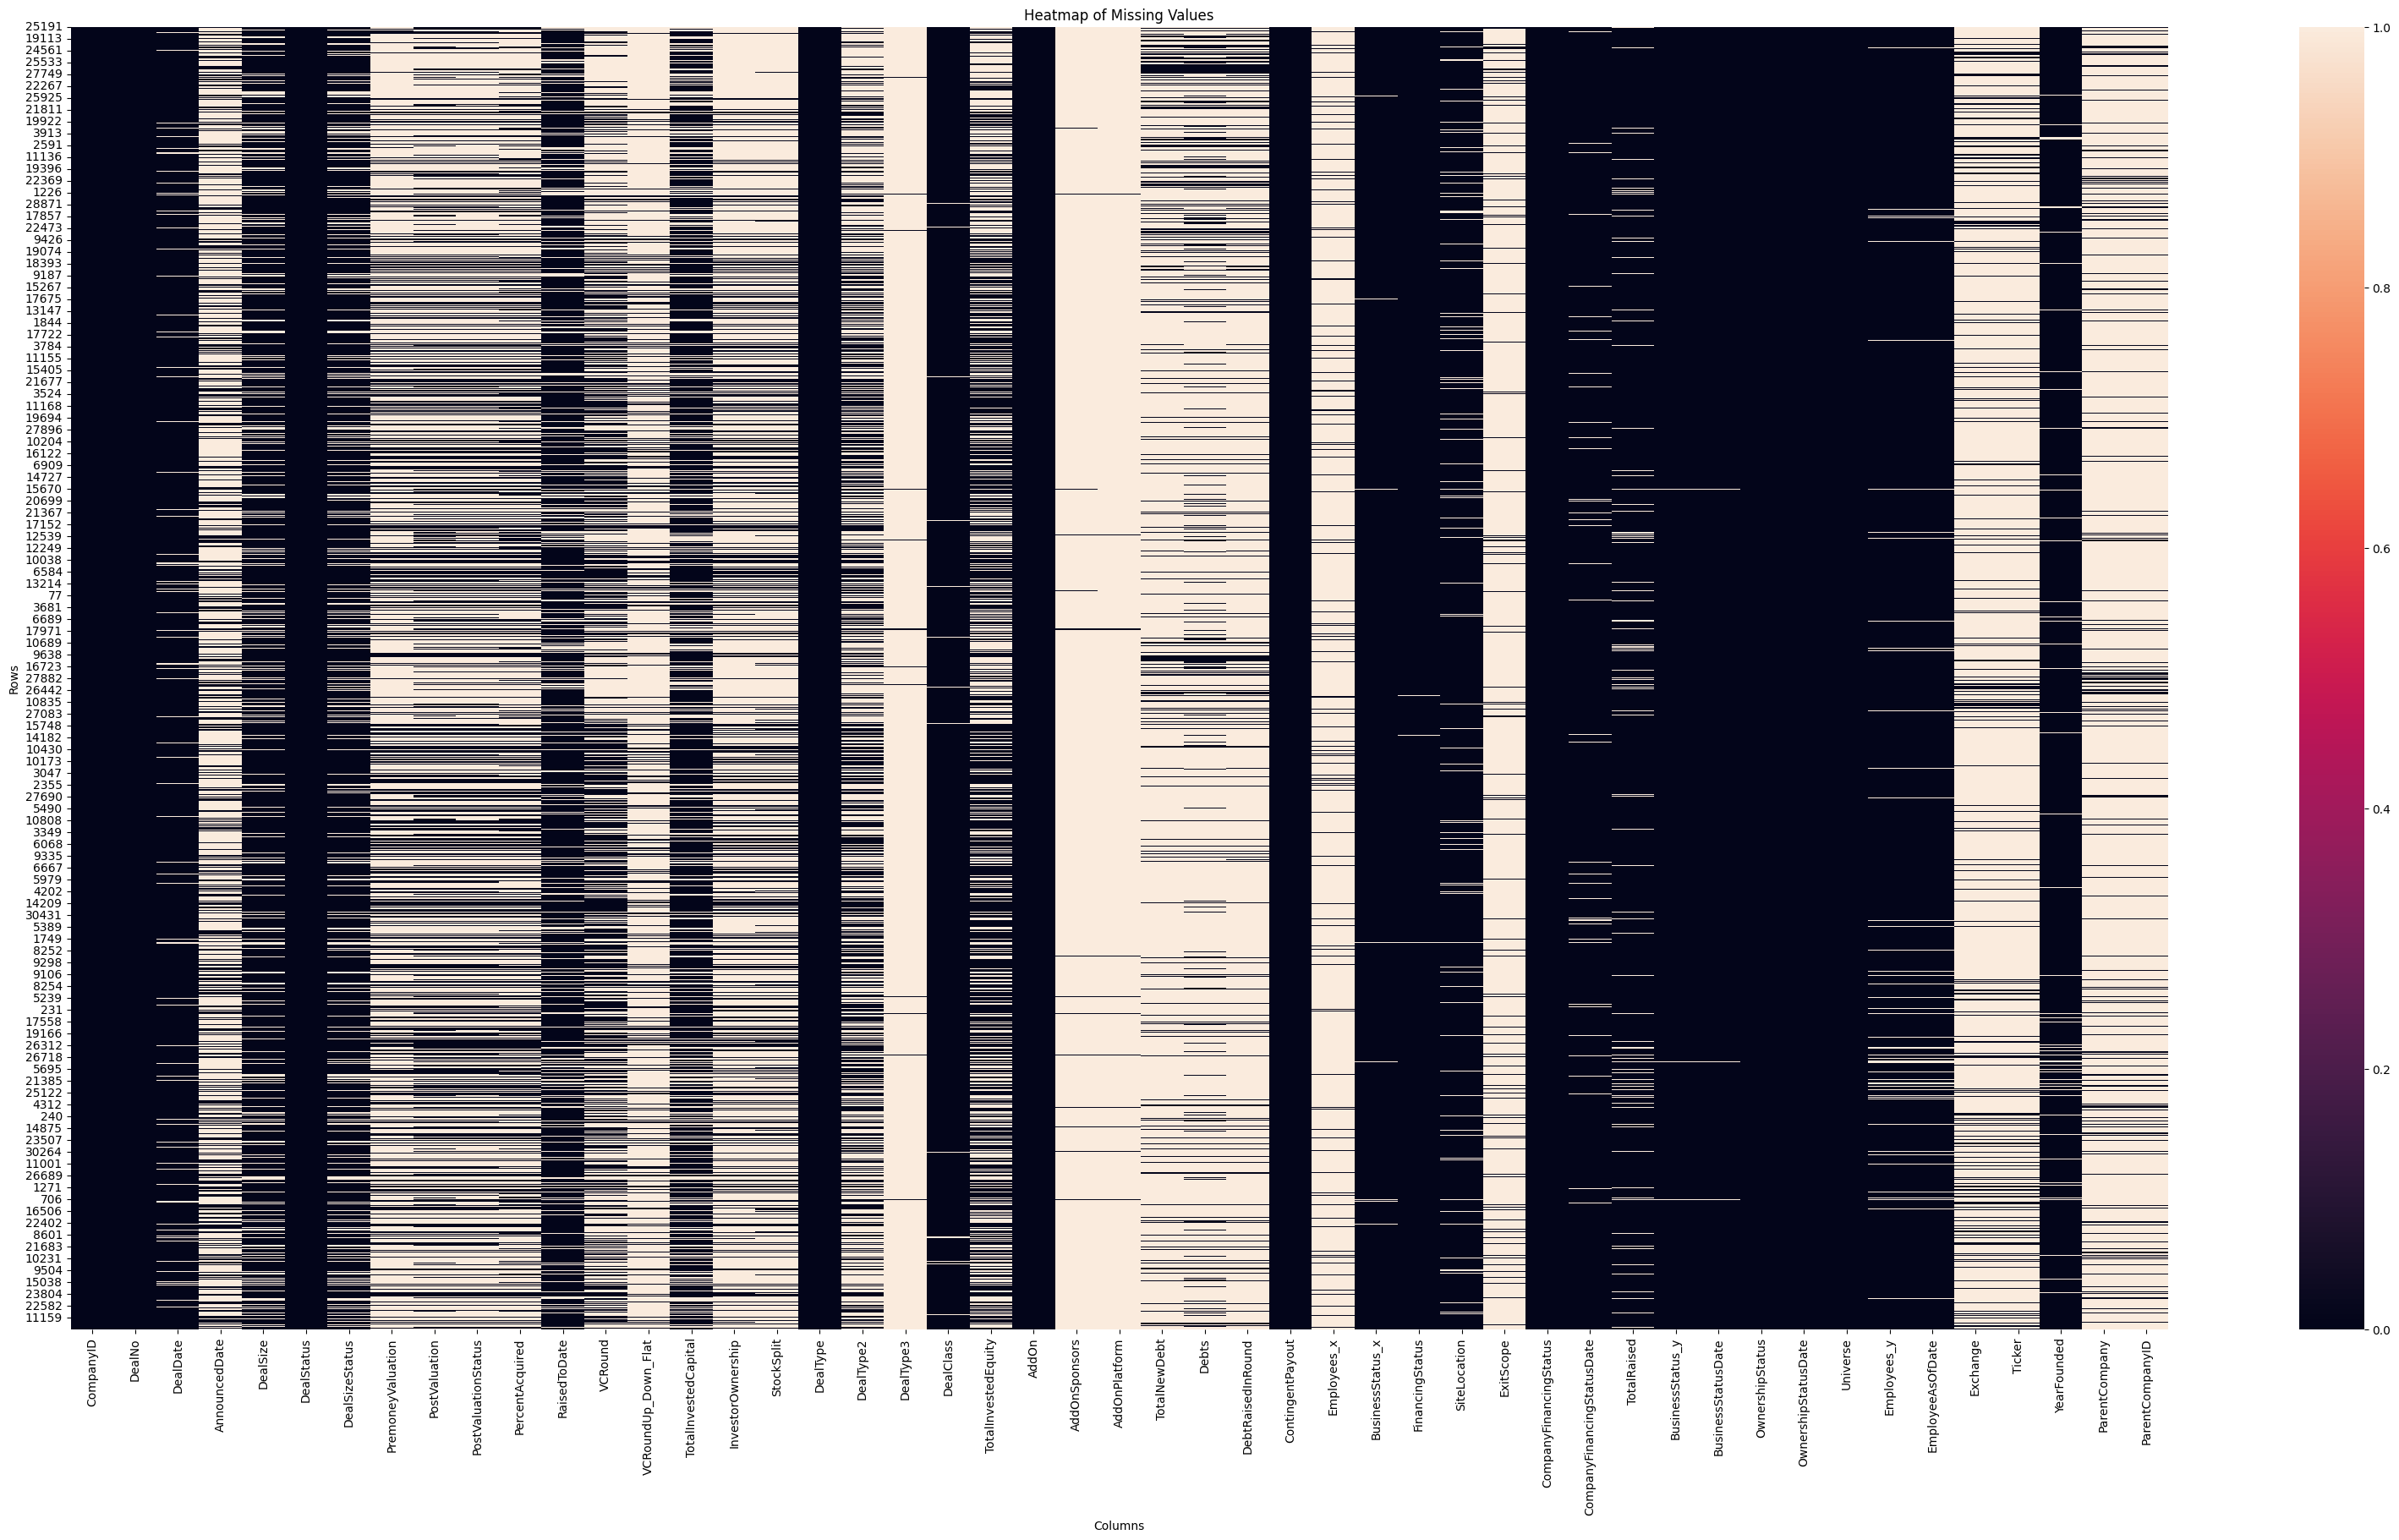

In [517]:
plt.figure(figsize=(40, 20))
sns.heatmap(df.isnull(), cbar=True)
plt.title('Heatmap of Missing Values')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

Upon visual inspection, it seems like DealType3, AddOnSponsors, AddOnPlatform are too sparse to estimate PostValuation.

### Post Valuation Missingness

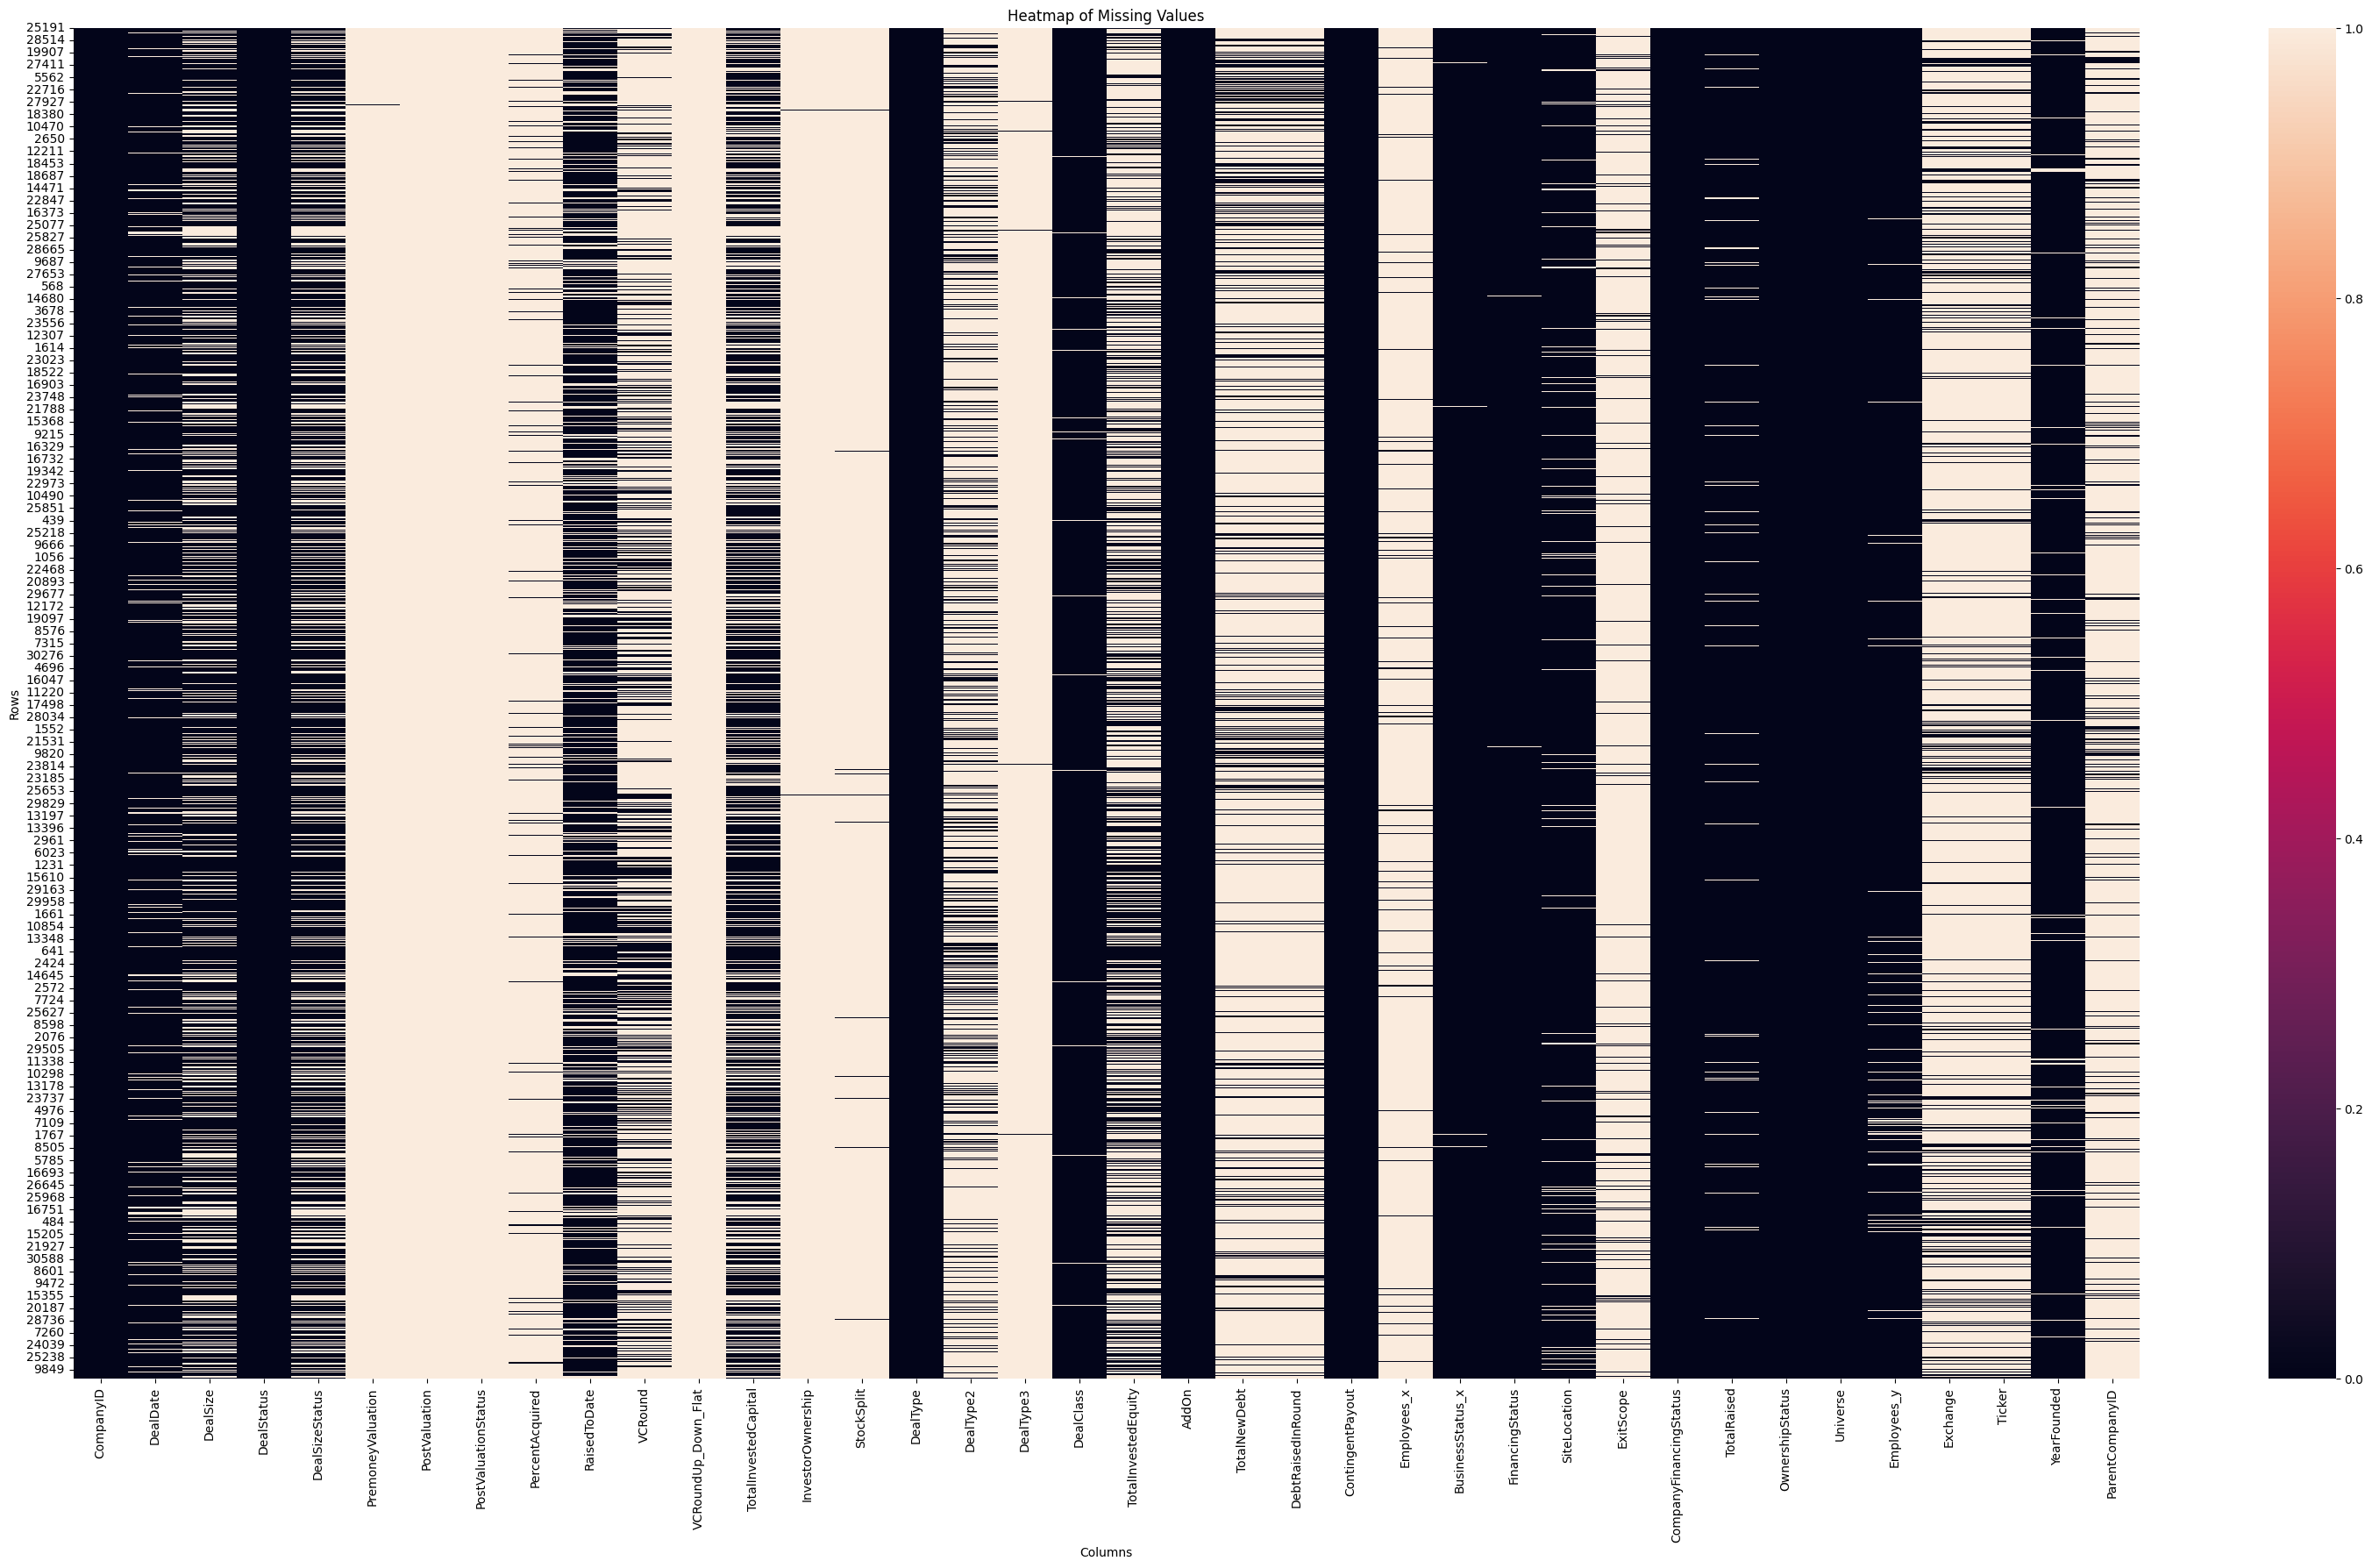

In [447]:
df_missing = df[df['PostValuation'].isna()].drop(['DealNo', 'OwnershipStatusDate', 'AddOnSponsors', 'AddOnPlatform', 'BusinessStatus_y', 'ParentCompany',
                                      'CompanyFinancingStatusDate', 'EmployeeAsOfDate', 'AnnouncedDate', 'BusinessStatusDate'], axis = 1)
plt.figure(figsize=(38, 20))
sns.heatmap(df_missing.isnull(), cbar=True)
plt.title('Heatmap of Missing Values')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

From inspecting where PostValuation is missing, we observe that PremoneyValuation, InvestorOwnership, PostValuation,StockSplit, and Employees are also frequently missing in the same rows. This co-missingness suggests that these variables are not reliable predictors for imputing PostValuation, as they are often unavailable when it's needed.

### Numerical Features

/Users/peiyuanlee/miniforge3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/peiyuanlee/miniforge3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/peiyuanlee/miniforge3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/peiyuanlee/miniforge3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

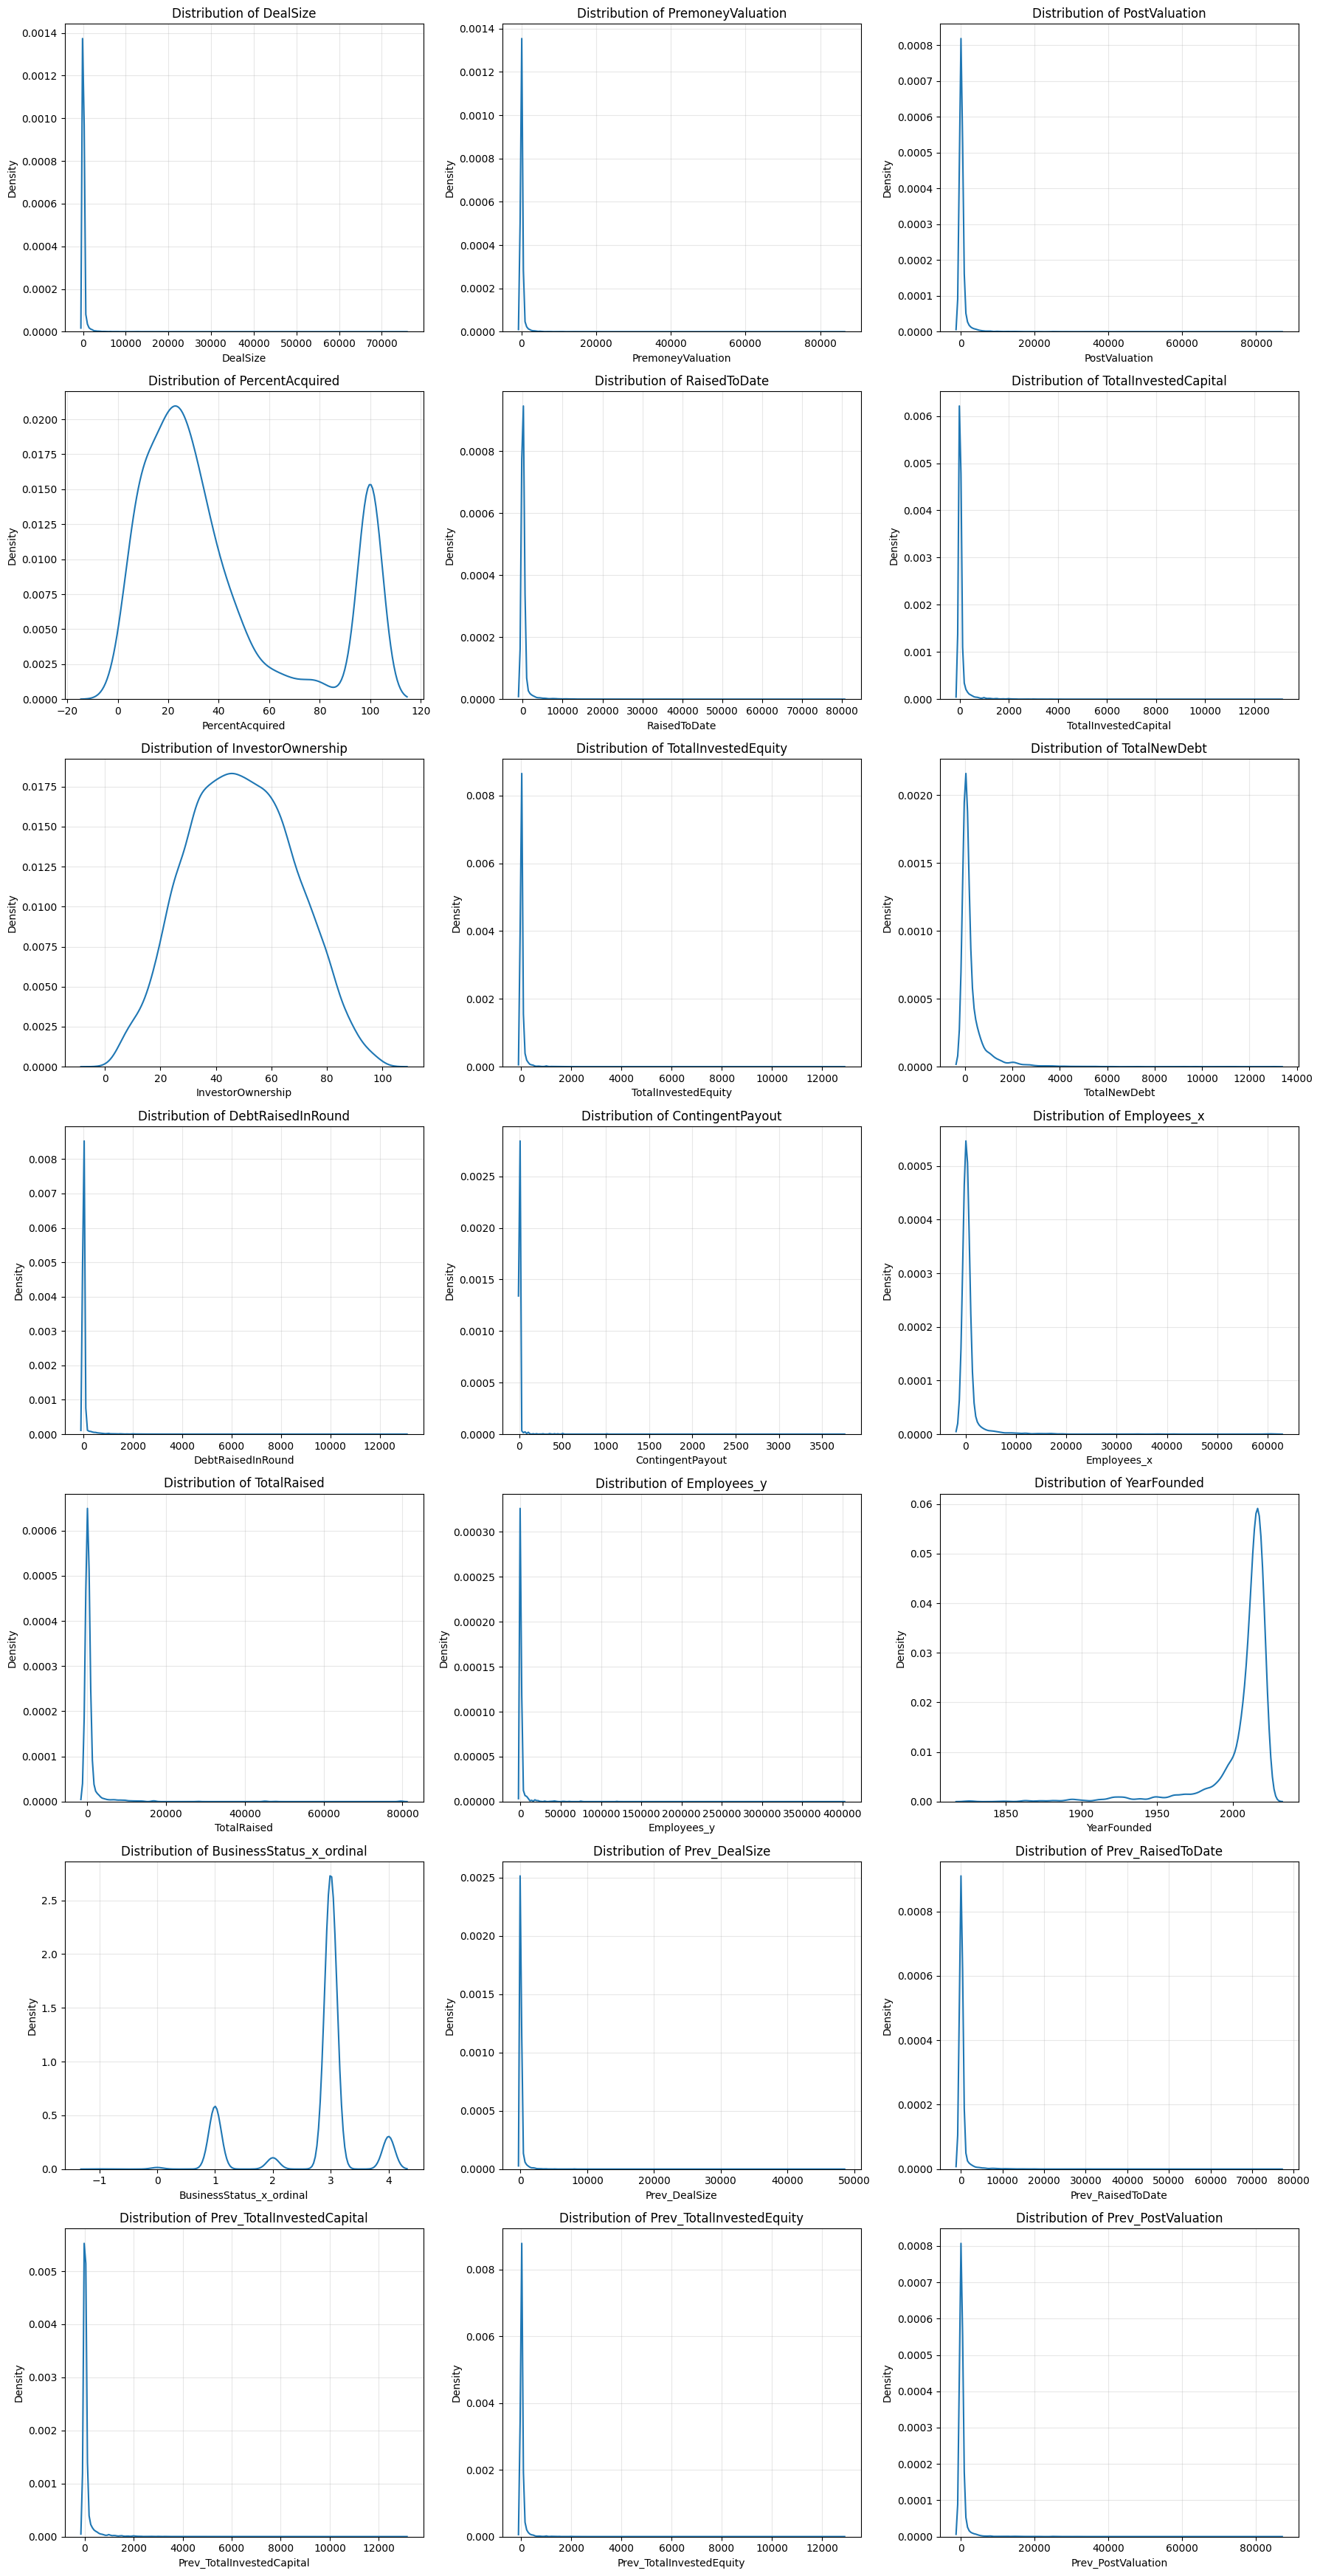

In [ ]:
numerical_features = df.select_dtypes(include=['float64']).columns.tolist()

n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.kdeplot(data=df[df[feature].notna()], x=feature, ax = ax)
    ax.set_title(f'Distribution of {feature}')
    ax.grid(True, alpha=0.3)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

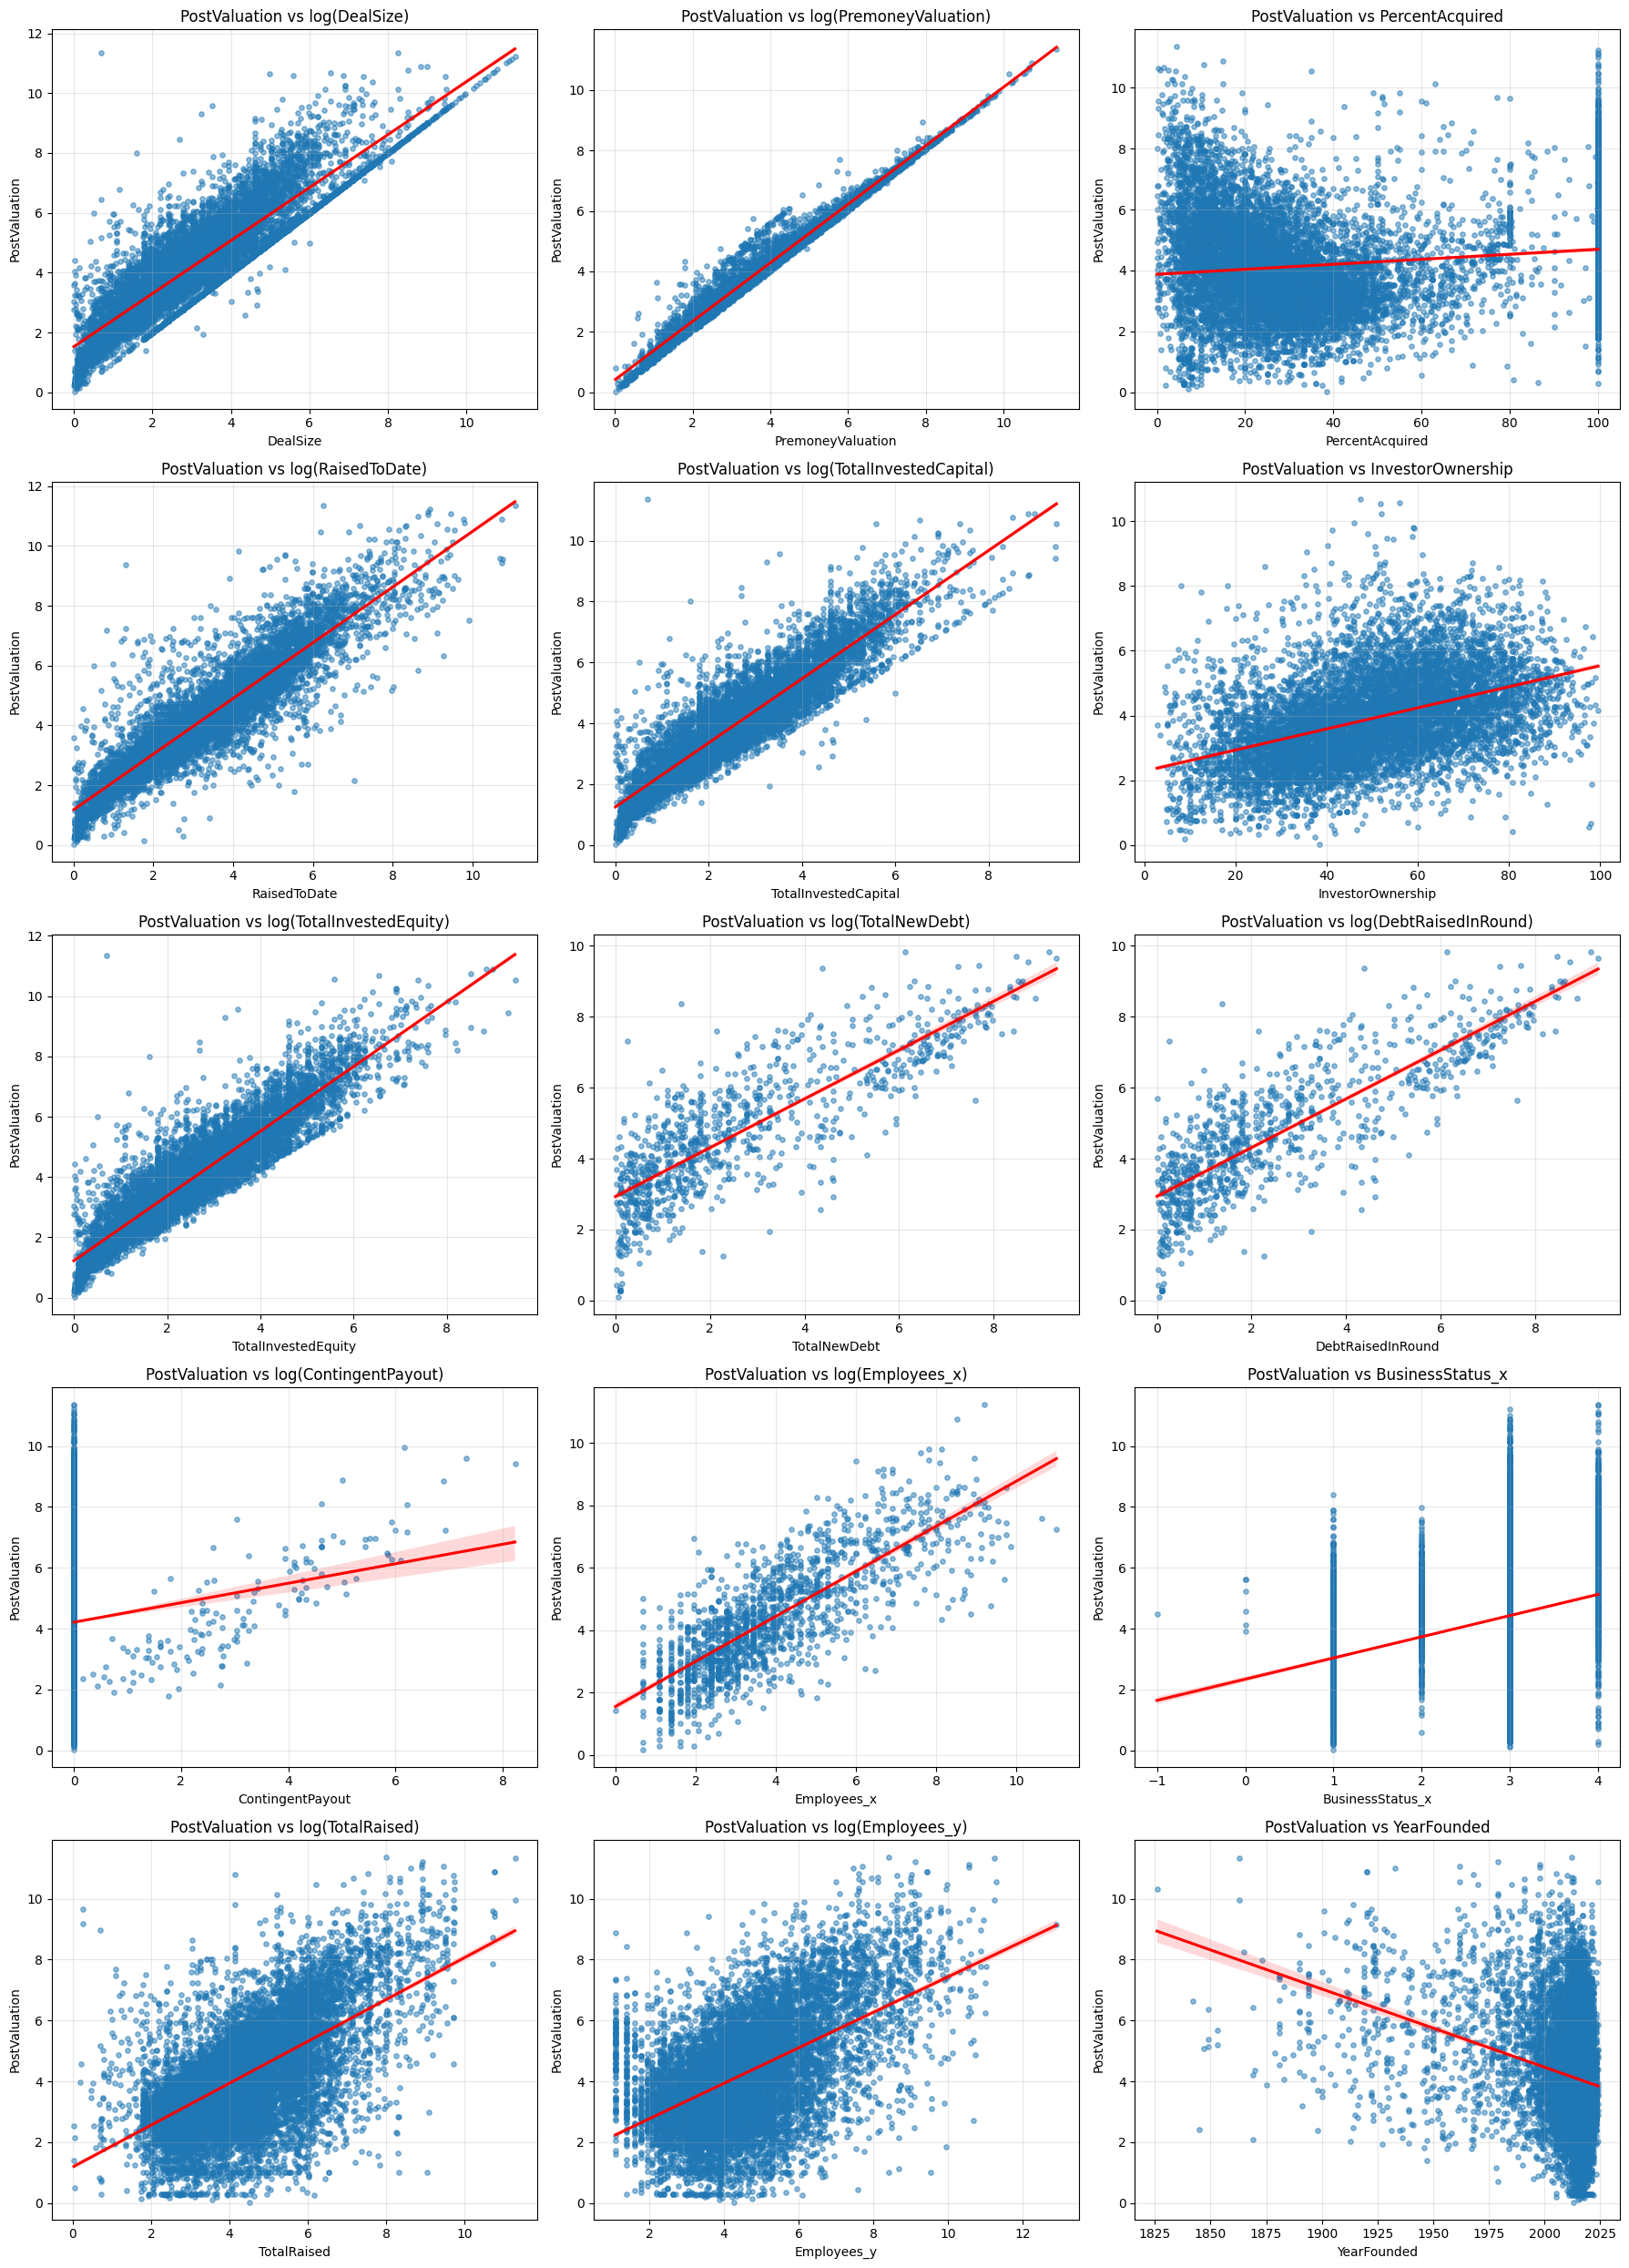

In [263]:
numerical_features = df.select_dtypes(include=['float64']).columns.tolist()
numerical_features = [f for f in numerical_features if f != 'PostValuation']


n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    #log transform for better visualizations
    x = np.log1p(df[feature]) if df[feature].skew() > 1 else df[feature]
    y = np.log1p(df['PostValuation'])  

    #scatterplot+regression
    sns.regplot(data=df, x=x, y=y,ax=ax,scatter_kws={'alpha': 0.5, 's': 15}, line_kws={'color': 'red'})
    
    if df[feature].skew() > 1:
        ax.set_title(f'PostValuation vs log({feature})')
    else:
        ax.set_title(f'PostValuation vs {feature}')
    ax.grid(True, alpha=0.3)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

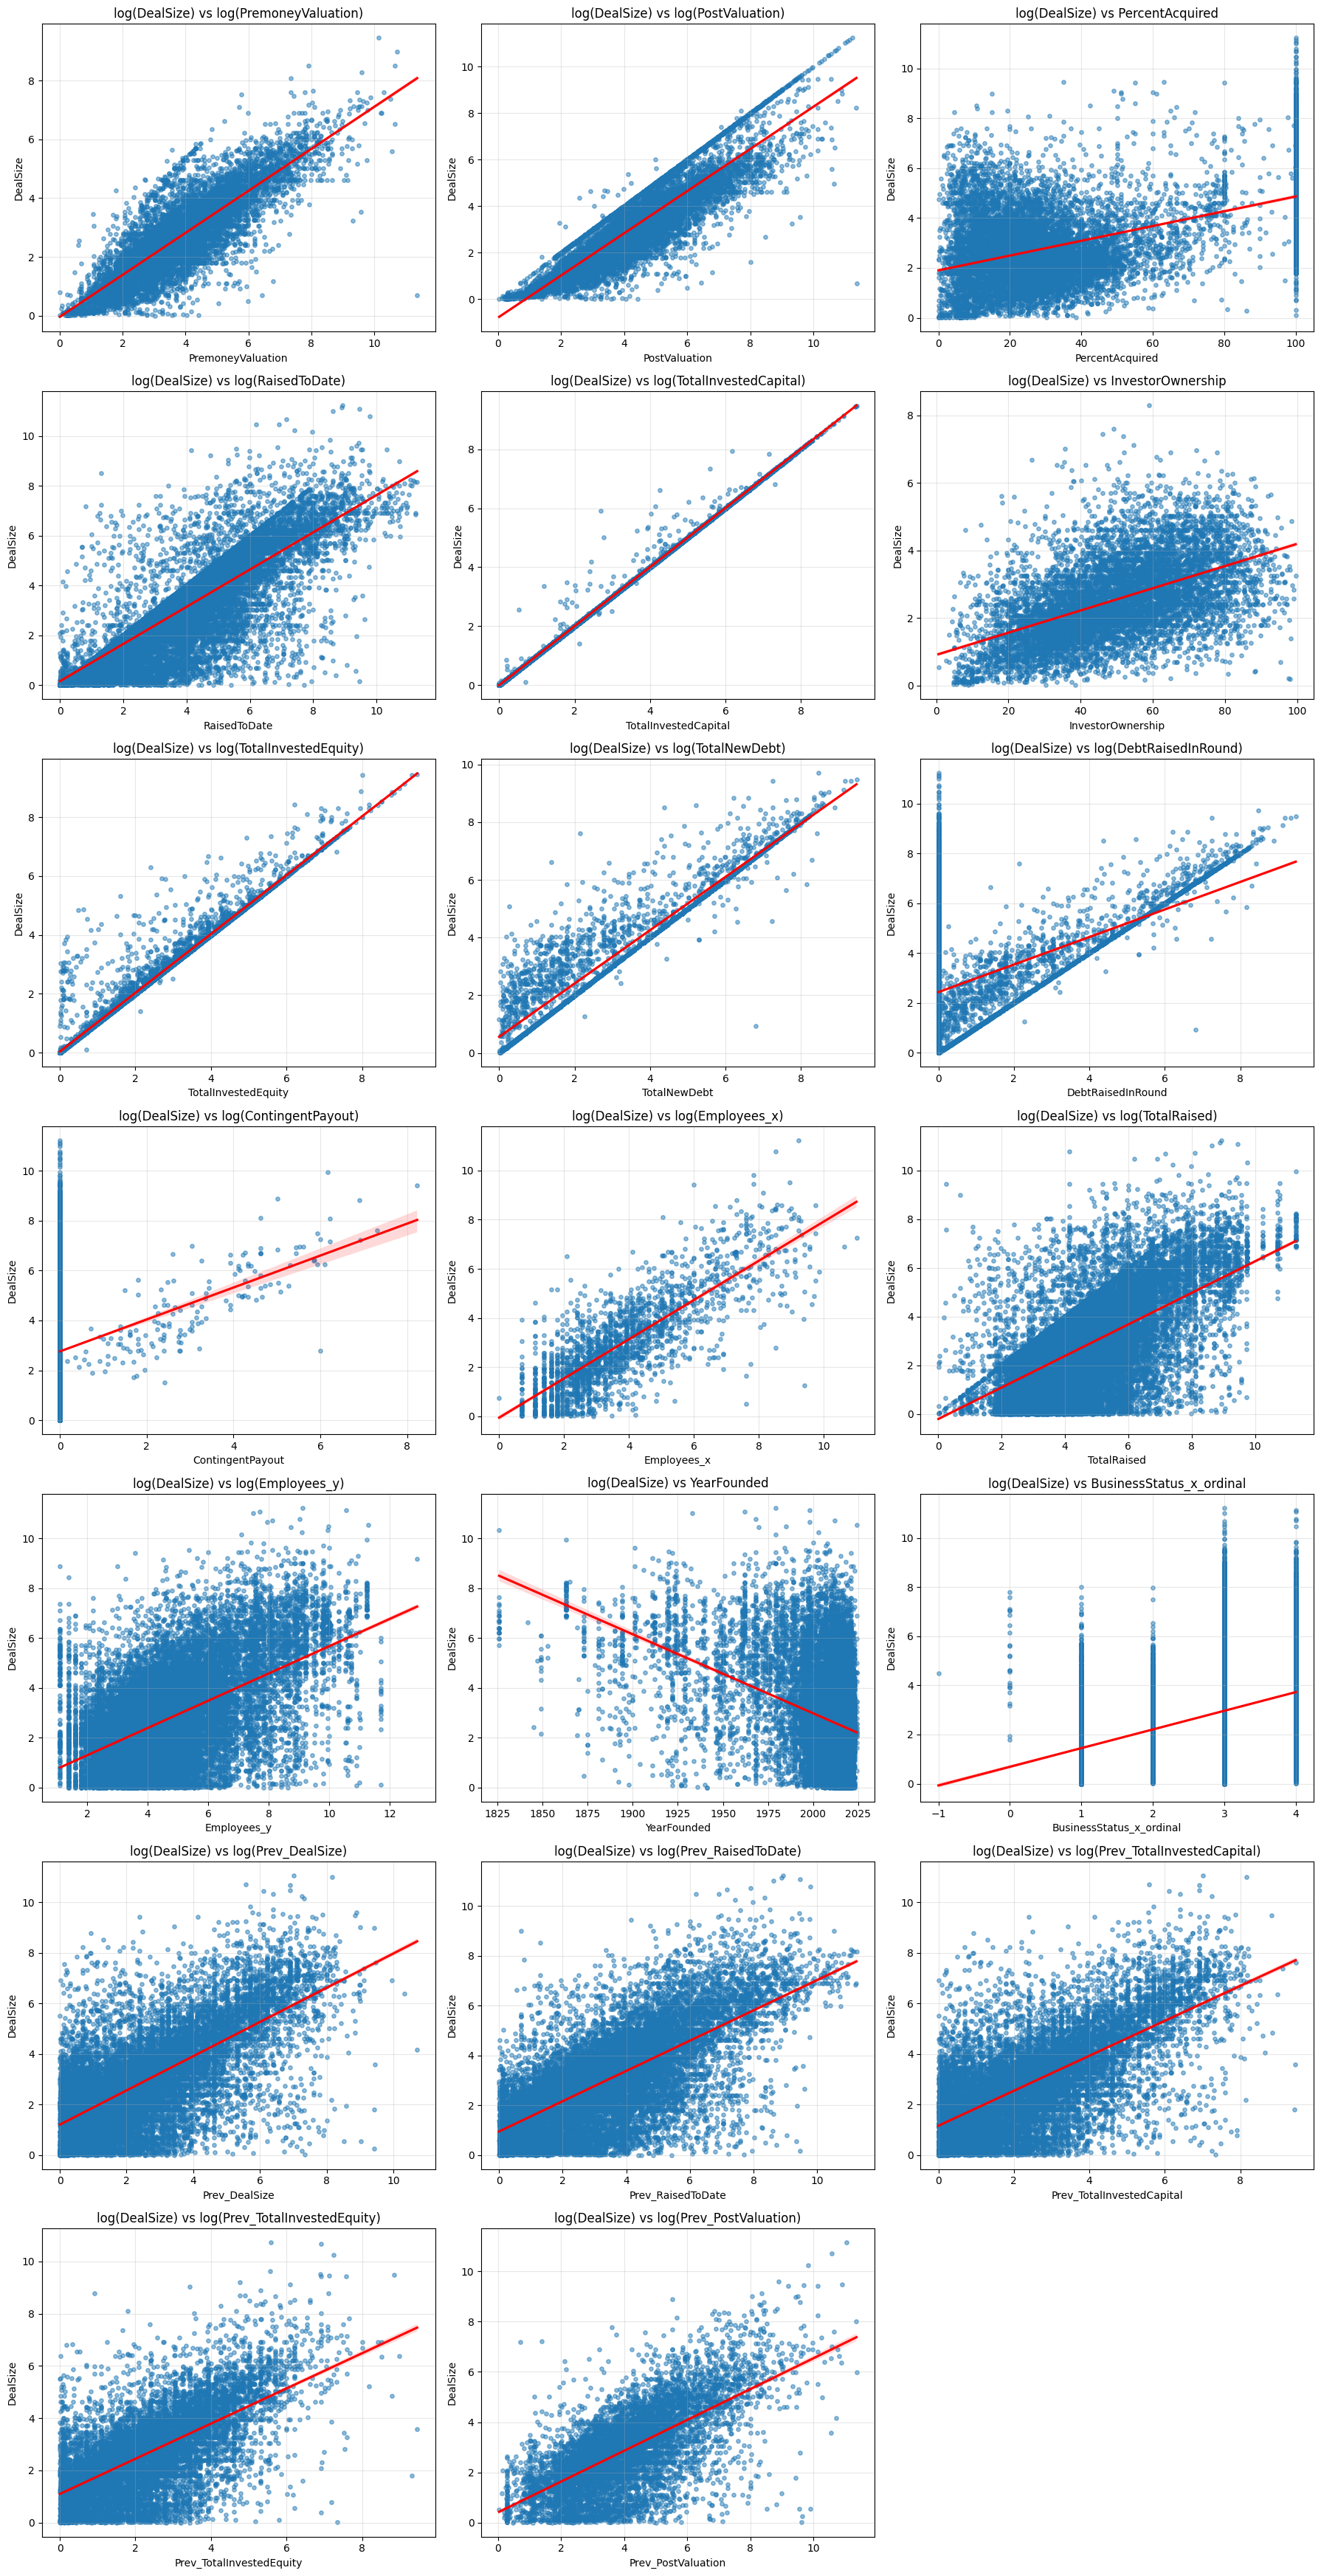

In [793]:
numerical_features = df.select_dtypes(include=['float64']).columns.tolist()
numerical_features = [f for f in numerical_features if f != 'DealSize']


n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    #log transform for better visualizations
    x = np.log1p(df[feature]) if df[feature].skew() > 1 else df[feature]
    y = np.log1p(df['DealSize'])  

    #scatterplot+regression
    sns.regplot(data=df, x=x, y=y,ax=ax,scatter_kws={'alpha': 0.5, 's': 15}, line_kws={'color': 'red'})
    
    if df[feature].skew() > 1:
        ax.set_title(f'log(DealSize) vs log({feature})')
    else:
        ax.set_title(f'log(DealSize) vs {feature}')
    ax.grid(True, alpha=0.3)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Time/ Previous Data

Since valuations are theoretically dependent on historical deal activity, we engineered temporal features that incorporate information from past deals to better inform the model.

In [568]:
df['Prev_DealSize'] = df.groupby('CompanyID')['DealSize'].shift(1)
df['Prev_RaisedToDate'] = df.groupby('CompanyID')['RaisedToDate'].shift(1)
df['Prev_TotalInvestedCapital'] = df.groupby('CompanyID')['TotalInvestedCapital'].shift(1)
df['Prev_TotalInvestedEquity']= df.groupby('CompanyID')['TotalInvestedEquity'].shift(1)
df['Prev_PostValuation']= df.groupby('CompanyID')['PostValuation'].shift(1)

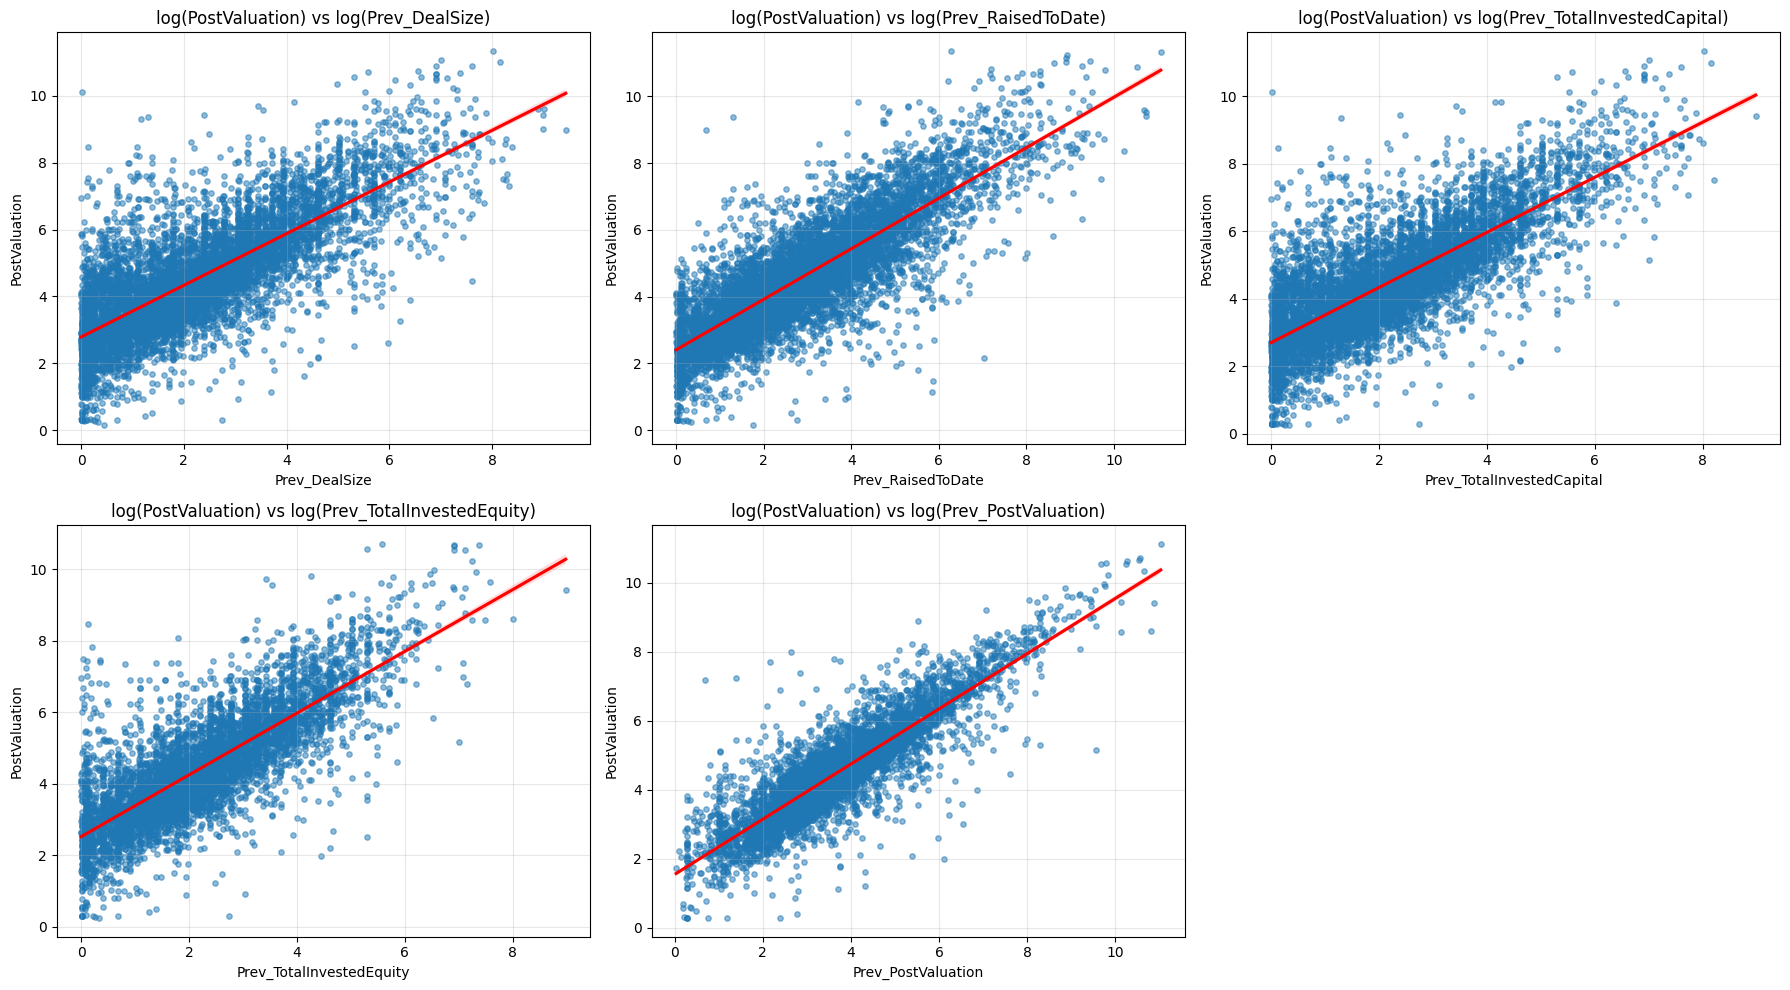

In [794]:
numerical_features = df.filter(regex='^Prev_').columns

n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    x = np.log1p(df[feature]) if df[feature].skew() > 1 else df[feature]
    y = np.log1p(df['PostValuation'])  
    #scatterplot+regression
    sns.regplot(data=df, x=x, y=y,ax=ax,scatter_kws={'alpha': 0.5, 's': 15}, line_kws={'color': 'red'})
    
    if df[feature].skew() > 1:
        ax.set_title(f'log(PostValuation) vs log({feature})')
    else:
        ax.set_title(f'log(PostValuation) vs {feature}')
    ax.grid(True, alpha=0.3)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

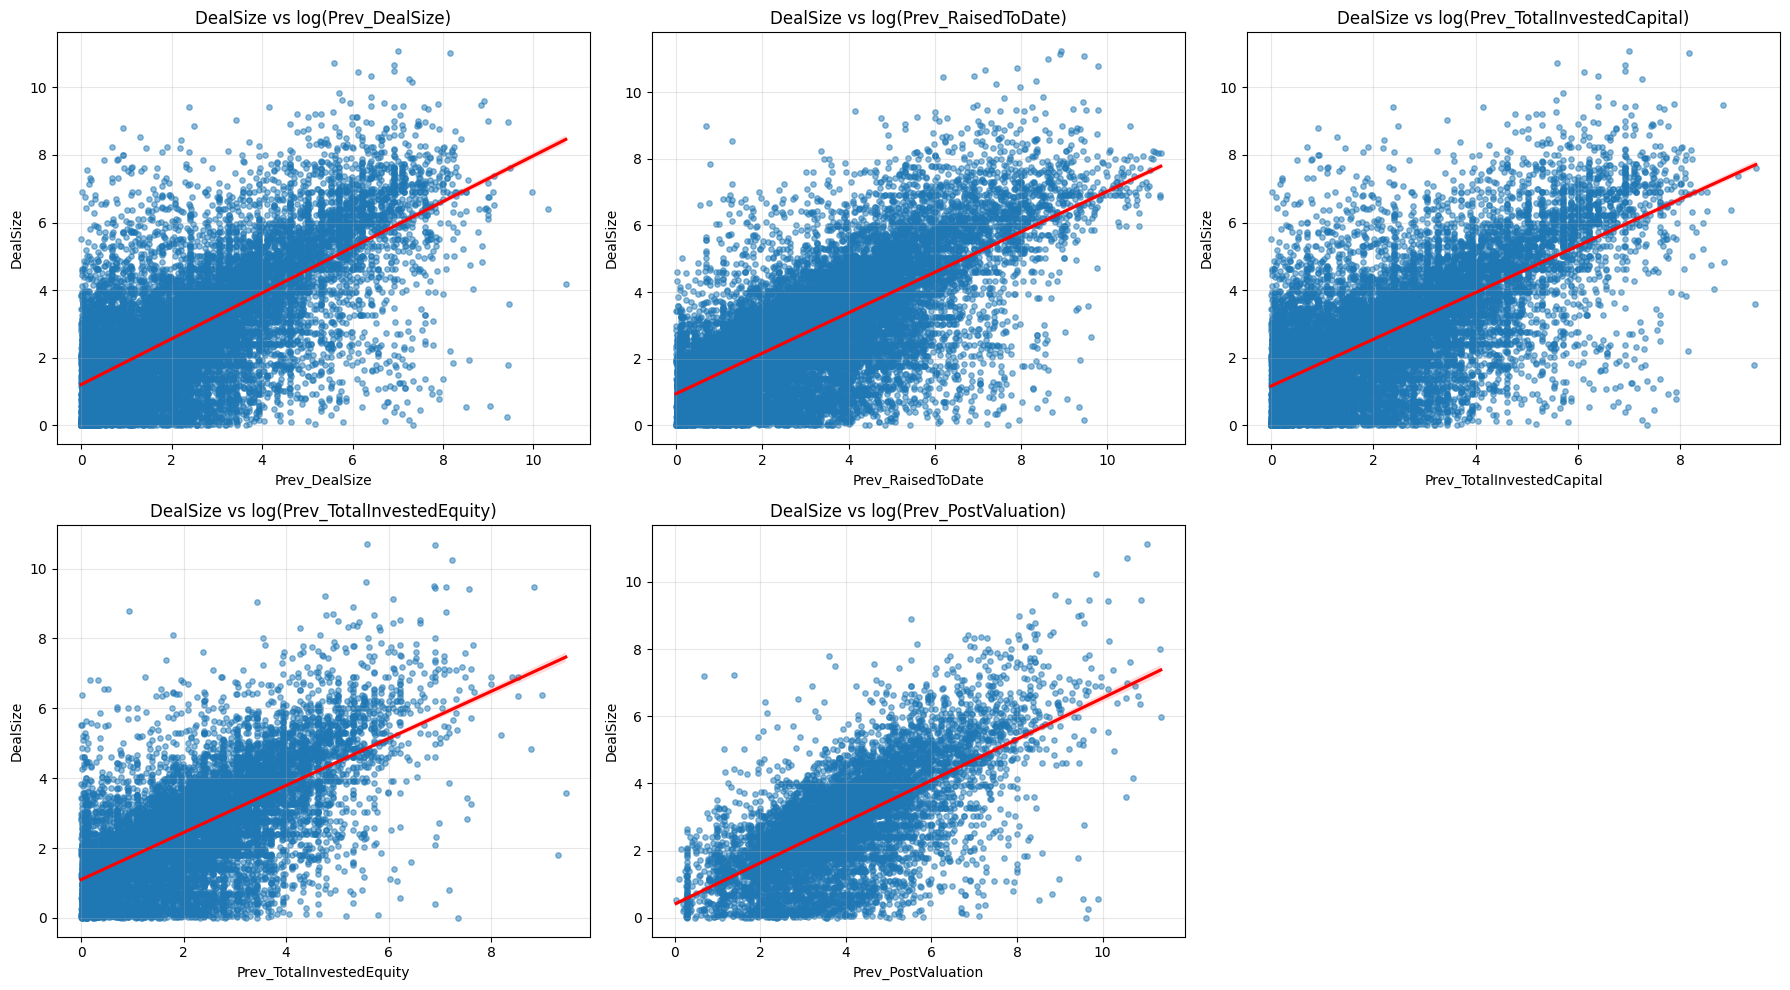

In [768]:
numerical_features = df.filter(regex='^Prev_').columns

n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    x = np.log1p(df[feature]) if df[feature].skew() > 1 else df[feature]
    y = np.log1p(df['DealSize'])  
    #scatterplot+regression
    sns.regplot(data=df, x=x, y=y,ax=ax,scatter_kws={'alpha': 0.5, 's': 15}, line_kws={'color': 'red'})
    
    if df[feature].skew() > 1:
        ax.set_title(f'DealSize vs log({feature})')
    else:
        ax.set_title(f'DealSize vs {feature}')
    ax.grid(True, alpha=0.3)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Universe

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
encode_Universe = pd.DataFrame( mlb.fit_transform(df['Universe'].apply(lambda x: [i.strip() for i in x.split(',')])),
    columns=[f'is_{label}' for label in mlb.classes_],
    index= df.index
)

df = pd.concat([df, encode_Universe], axis=1)

/Users/peiyuanlee/miniforge3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/peiyuanlee/miniforge3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/peiyuanlee/miniforge3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/peiyuanlee/miniforge3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

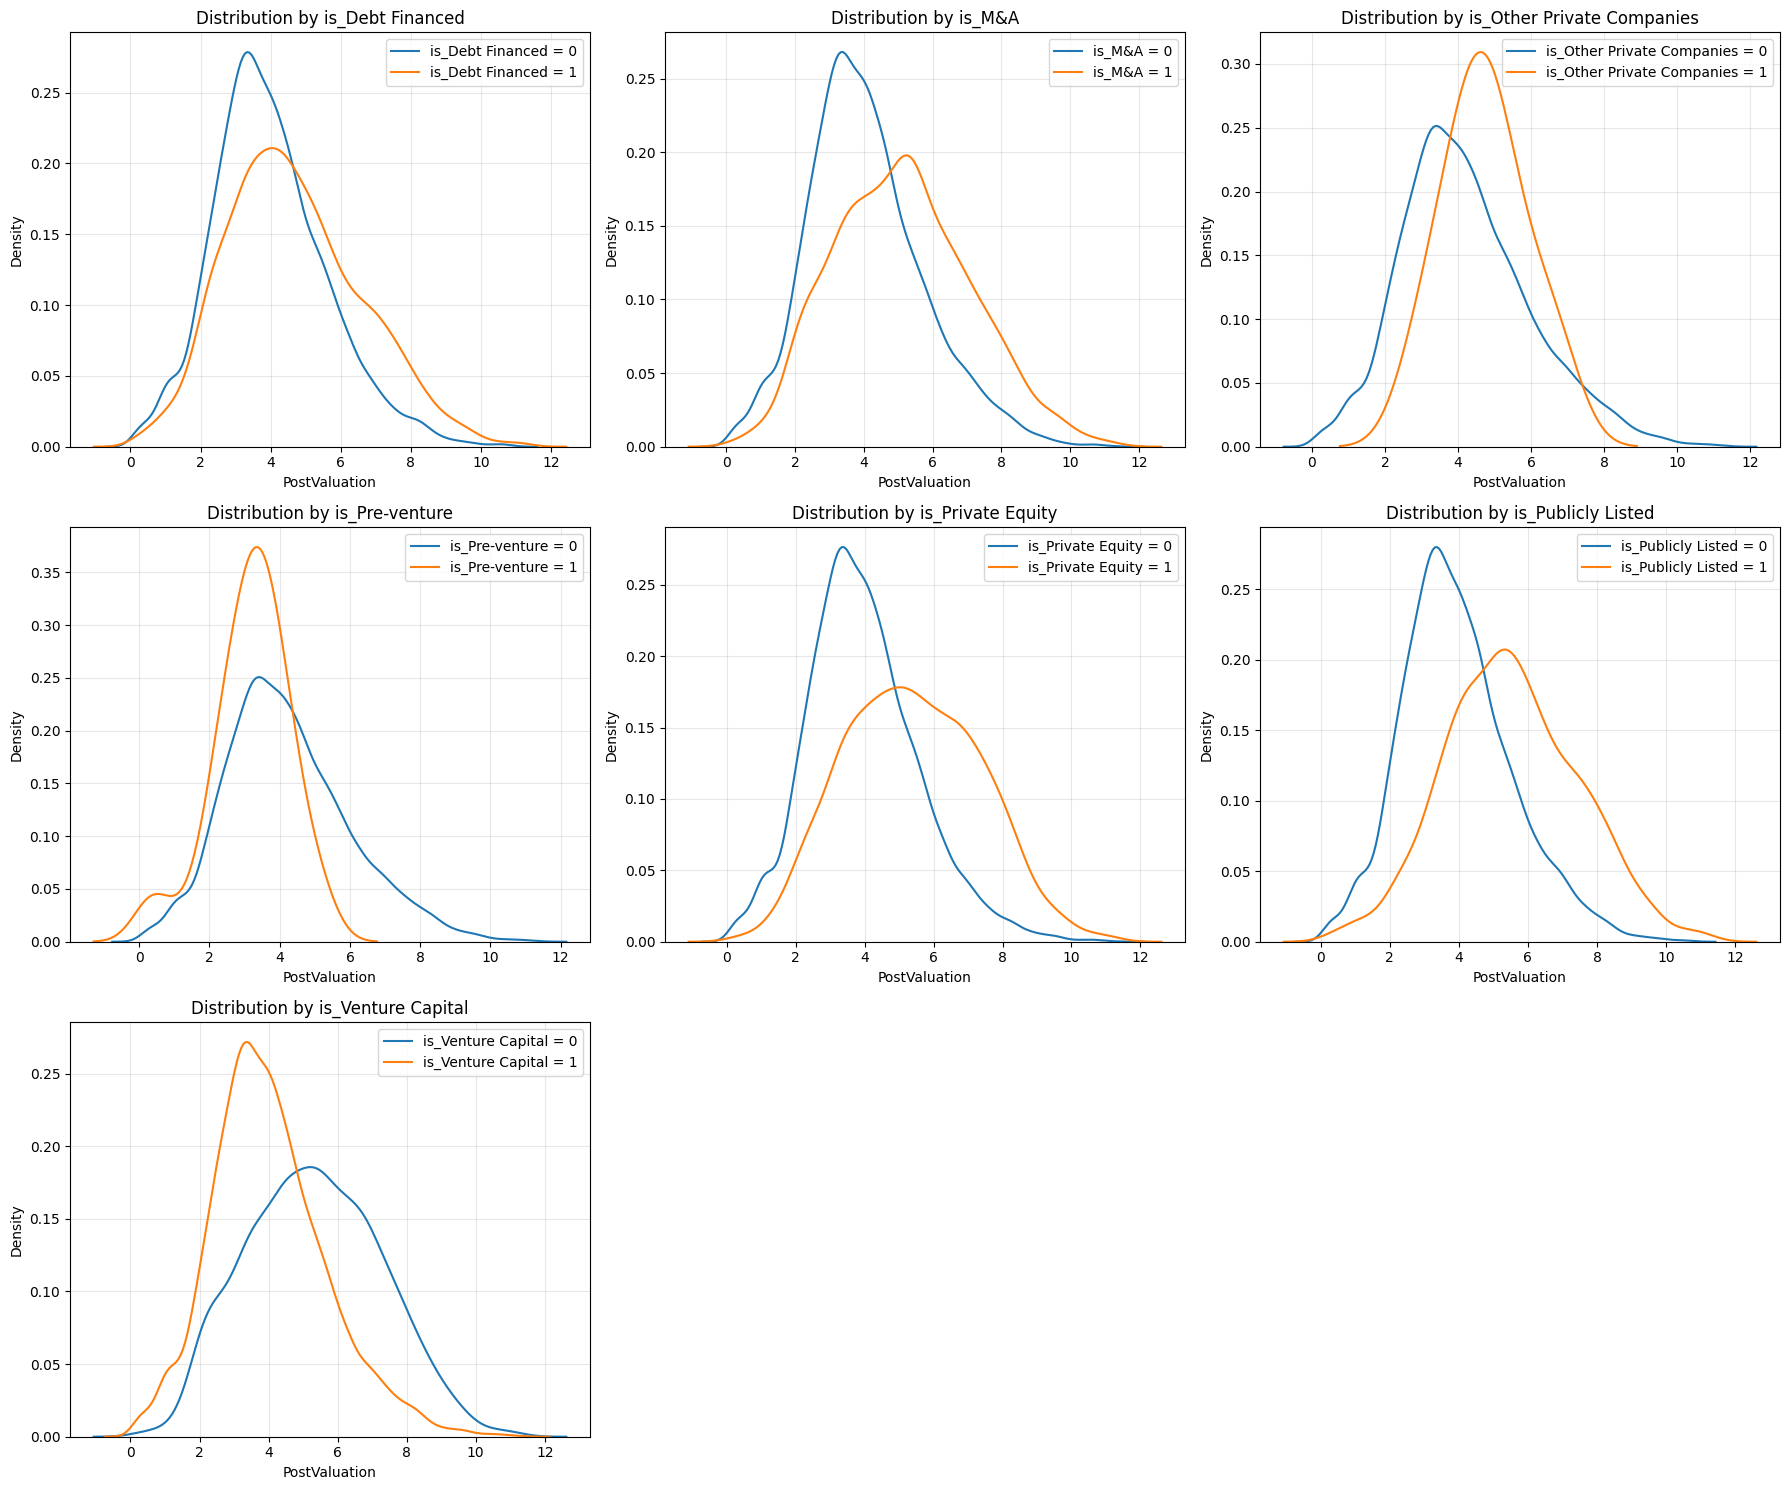

In [ ]:
features = encode_Universe.columns.tolist()

n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    for category in [0, 1]:
        sns.kdeplot(
            data=df[df[feature] == category],
            x=np.log1p(df.loc[df[feature] == category, 'PostValuation']),
            label=f'{feature} = {category}',
            ax=ax
        )
    ax.set_title(f'Distribution by {feature}')
    ax.grid(True, alpha=0.3)
    ax.legend()

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [809]:
from scipy.stats import ttest_ind
features = encode_Universe.columns.tolist()

for f in features:
    group_0 = np.log1p(df[df[f] == 0]['PostValuation']).dropna()
    group_1 = np.log1p(df[df[f] == 1]['PostValuation']).dropna()

    t_stat, p = ttest_ind(group_0, group_1, equal_var=False)
    print(f"T-test p-value for {f}: {p}")


T-test p-value for is_Debt Financed: 3.307617405837173e-88
T-test p-value for is_M&A: 1.2146540422555756e-98
T-test p-value for is_Other Private Companies: 0.1240545902637546
T-test p-value for is_Pre-venture: 2.330704666236002e-06
T-test p-value for is_Private Equity: 6.414791943286369e-202
T-test p-value for is_Publicly Listed: 1.2305050836791642e-229
T-test p-value for is_Venture Capital: 8.282469824938959e-147


Universe contains unstructured information indicating whether or not the company is debt financed, publicly listed, been merged or acquired and or other characteristics. We one hot encode this data to hopefully enable the model to capture attributes as potential predictors of valuation. Upon visual inspection and performing t-tests, we observe significant differences in post-valuation distributions across these attributes, suggesting they may serve as informative predictors.

### Debt

In [530]:
df['Debts'].isna().mean()

0.8062907431551499

In [534]:
df['DebtRaisedInRound'].isna().mean()

0.8522490221642764

In [535]:
df['TotalNewDebt'].isna().mean()

0.8523468057366362

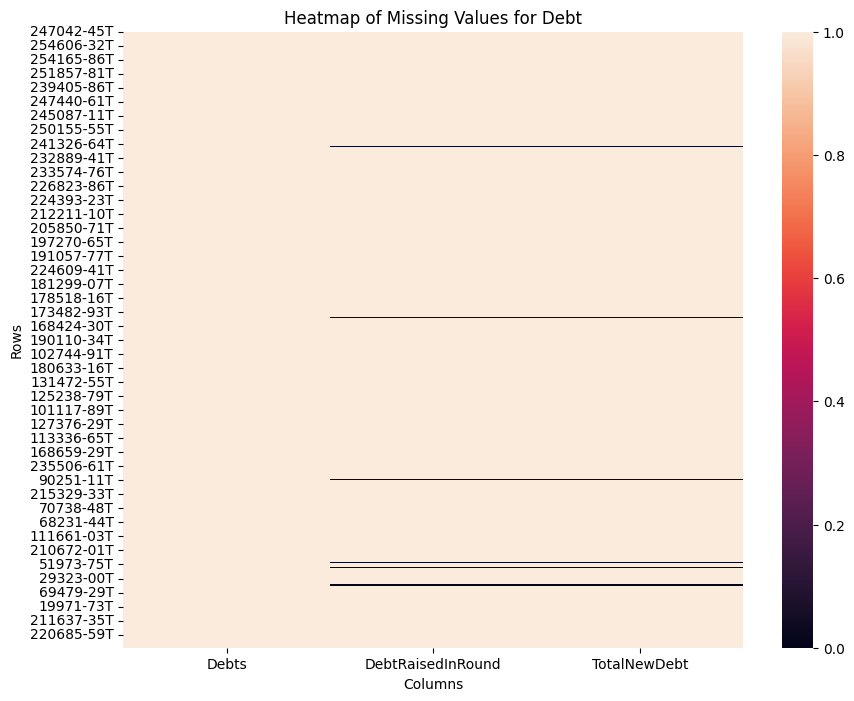

In [527]:
plt.figure(figsize=(10, 8))
sns.heatmap(deals[deals['Debts'].isna()][['Debts', 'DebtRaisedInRound', 'TotalNewDebt']].isnull(), cbar=True)
plt.title('Heatmap of Missing Values for Debt')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

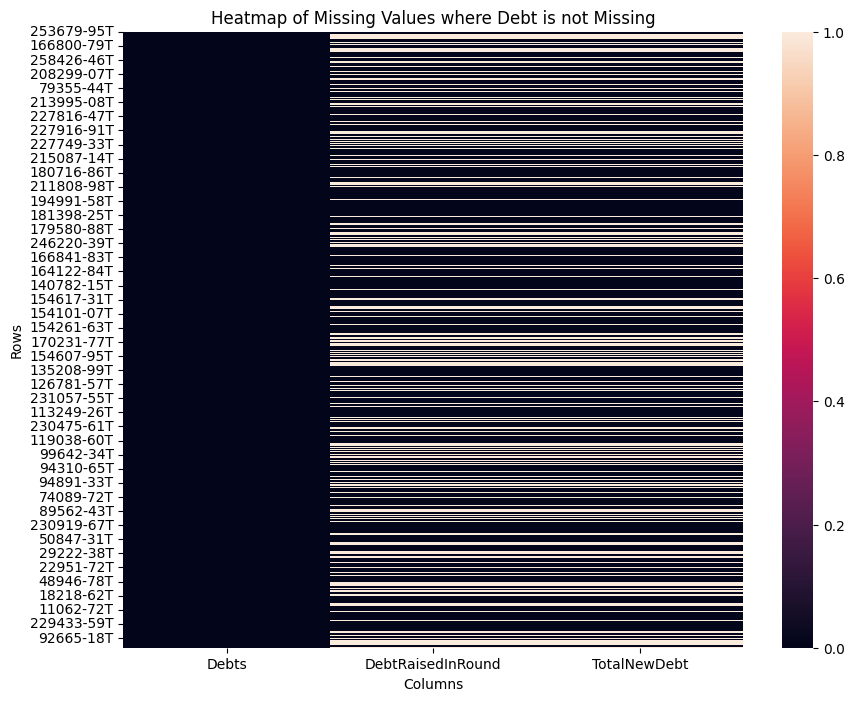

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(deals[deals['Debts'].notna()][['Debts', 'DebtRaisedInRound', 'TotalNewDebt']].isnull(), cbar=True)
plt.title('Heatmap of Missing Values where Debt is not Missing')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [548]:
df.loc[df['DebtRaisedInRound'].isna() & df['Debts'].isna(), 'DebtRaisedInRound'] = 0

Debts, which contains unstructured descriptions of deal-related debt, is missing in ~80% of cases. In these cases, we also observe that DebtRaisedInRound and TotalNewDebt are frequently missing. Conversely, when Debts is not missing, DebtRaisedInRound is reported in ~73% of those rows. Based on this pattern, we imputed DebtRaisedInRound with 0 when Debts is missing, under the assumption that the absence of debt information implies no debt was raised.

### Deal Types

In [311]:
df['DealType'].value_counts()

DealType
Later Stage VC                                5787
Early Stage VC                                5014
Seed Round                                    4005
Debt - General                                2147
Accelerator/Incubator                         1873
Grant                                         1697
Merger/Acquisition                            1549
PIPE                                          1246
Buyout/LBO                                    1044
PE Growth/Expansion                            962
Debt Refinancing                               796
Secondary Transaction - Private                765
IPO                                            756
Debt - PPP                                     720
Angel (individual)                             485
Public Investment 2nd Offering                 315
Reverse Merger                                 237
Secondary Transaction - Open Market            221
Spin-Off                                       146
Corporate             

Since there are too many distinct DealTypes and DealClass provides similar information at a less granular level, we use DealClass as a predictor instead of DealType.

In [748]:
df['DealType2'].value_counts()[:10]

DealType2
Seed Round               3719
Series A                 3421
Series B                 1690
Series C                  848
Acquisition Financing     581
Angel (individual)        470
Series A1                 396
Corporate Divestiture     394
Series D                  385
Series A2                 197
Name: count, dtype: int64

In [749]:
df['funding_stages']= df['DealType2'].apply(lambda x: None if x is None else (x.split()[1][0] if 'Series' in x.split() else ('Angel' if 'Angel' in x.split() else ('Seed' if 'Seed' in x.split() else None))))

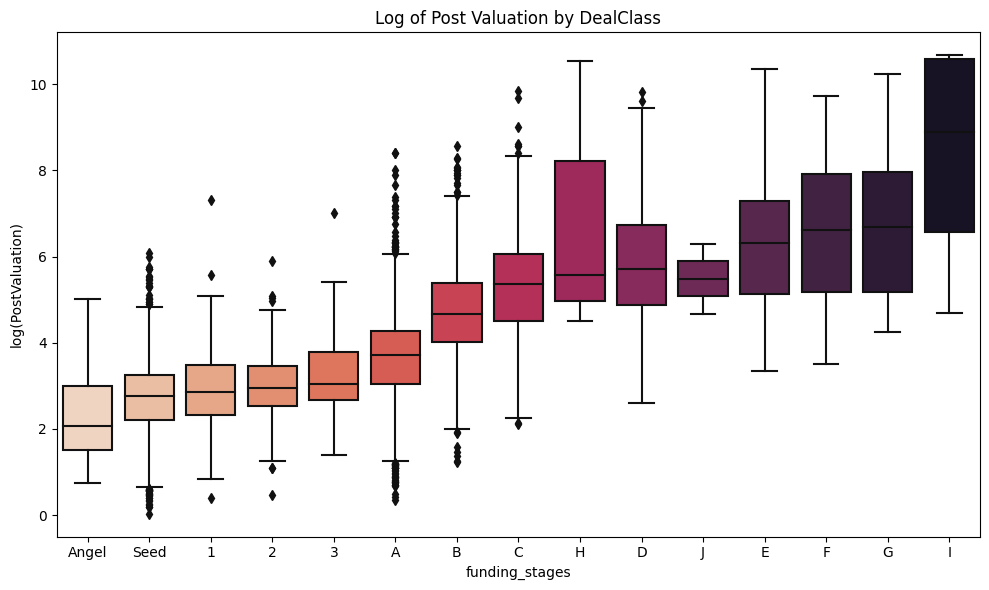

In [753]:
# apparently series1/2/3 are not legit terms wthelly??? double check later 
median_order = df[df['PostValuation'].notna()].groupby('funding_stages')['PostValuation'].median().sort_values().index
plt.figure(figsize=(10, 6))
sns.boxplot(data = df[df['PostValuation'].notna()],x = 'funding_stages',  y = np.log1p(df[df['PostValuation'].notna()]['PostValuation']), palette = 'rocket_r', order = median_order)

plt.ylabel('log(PostValuation)')
plt.title('Log of Post Valuation by DealClass')
plt.tight_layout()
plt.show()

Funding Stages provide some insight into the valuation of the company, with later stages having a higher PostValuation value. Thus, this may be a good predictor for PostValuation.

In [689]:
def order_letters_and_nums(x):
    if x == '1' or x=='2' or x=='3':
        return 1
    elif x == 'Angel' or x == 'Seed':
        return 0
    elif x is None:
        return None
    else:
        return sorted([i for i in df['funding_stages'].unique() if i not in [None,'1', '2', '3']]).index('A') + 2
    
df['funding_stages'] = df['funding_stages'].apply(order_letters_and_nums)

### Deal Class

In [66]:
df['DealClass'].value_counts()

DealClass
Venture Capital      15270
Debt                  3900
Other                 3621
Corporate             2955
Private Equity        2543
Public Investment     1097
Individual             924
Bankruptcy             107
Hedge Fund              22
Out of Business          2
Name: count, dtype: int64

In [85]:
df[df['DealClass'] == 'Bankruptcy'].sort_values(by = ['CompanyID', 'DealDate'])[['CompanyID', 'PremoneyValuation','PostValuation', 'DealType', 'OwnershipStatus', 'TotalRaised']]

CompanyID  PremoneyValuation  PostValuation                 DealType  \
8162    10057-15                NaN            NaN  Bankruptcy: Admin/Reorg   
28972   10189-99                NaN            NaN  Bankruptcy: Admin/Reorg   
28549   10189-99                NaN            NaN  Bankruptcy: Admin/Reorg   
16203   10200-61                NaN            NaN  Bankruptcy: Admin/Reorg   
8173    10287-10                NaN            NaN  Bankruptcy: Admin/Reorg   
...          ...                ...            ...                      ...   
24080   57642-49                NaN            NaN  Bankruptcy: Admin/Reorg   
3087    58960-09                NaN            NaN  Bankruptcy: Admin/Reorg   
7832   593605-72                NaN            NaN  Bankruptcy: Admin/Reorg   
3903    62181-28                NaN            NaN  Bankruptcy: Admin/Reorg   
2881    84538-72                NaN            NaN  Bankruptcy: Admin/Reorg   

                              OwnershipStatus   TotalRaised  
8162   Acquired/Merged (Operating Subsidiary)      2.551000  
28972                           Publicly Held   1412.000000  
28549                           Publicly Held   1412.000000  
16203                           Publicly Held   6690.000000  
8173                 Privately Held (backing)           NaN  
...                                       ...           ...  
24080                           Publicly Held    170.702993  
3087                            Publicly Held    152.700000  
7832                          Acquired/Merged           NaN  
3903                 Privately Held (backing)  16687.934373  
2881   Acquired/Merged (Operating Subsidiary)           NaN  

[107 rows x 6 columns]

impute bankrupt companies with 0?

In [71]:
df[df['DealClass'] == 'Out of Business']

PostValuation         DealType
278             NaN  Out of Business
4650            NaN  Out of Business

In [317]:
df[df['DealClass'].isna()]['DealType'].unique()
# all but platform creation is placed under the other bucket

array(['Grant', 'Secondary Transaction - Open Market', 'PIPE',
       'Secondary Transaction - Private', 'Seed Round',
       'Platform Creation'], dtype=object)

In [318]:
df[df['DealClass'] == 'Other']['DealType'].unique()

array(['Accelerator/Incubator', 'Grant',
       'Secondary Transaction - Private', 'Later Stage VC',
       'Joint Venture', 'Merger/Acquisition', 'Share Repurchase',
       'Secondary Transaction - Open Market', 'Corporate',
       'Product Crowdfunding', 'PIPE', 'Dividend', 'Undetermined',
       'Seed Round', 'PE Growth/Expansion', 'Sale-Lease back facility'],
      dtype=object)

In [321]:
df[df['DealType'] == 'Platform Creation']['DealClass'].value_counts()
# we impute deal class with private equity

DealClass
Private Equity    31
Name: count, dtype: int64

In [550]:
df.loc[(df['DealClass'].isna()) & (df['DealType'] == 'Platform Creation'), 'DealClass'] = 'Private Equity'
df.loc[df['DealClass'].isna(), 'DealClass'] = 'Other'

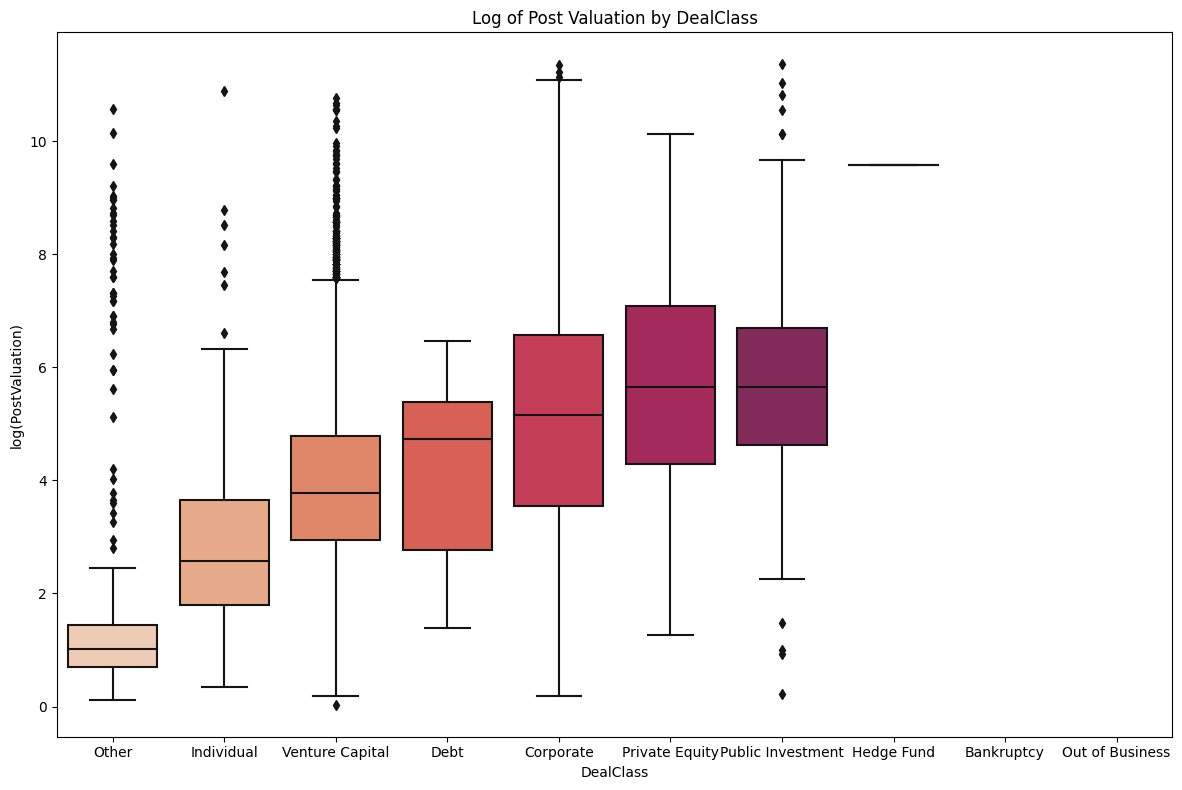

In [602]:
median_order = df.groupby('DealClass')['PostValuation'].median().sort_values().index
plt.figure(figsize=(12, 8))
sns.boxplot(data = df,x = 'DealClass',  y = np.log1p(df['PostValuation']), palette = 'rocket_r', order= median_order)

plt.ylabel('log(PostValuation)')
plt.title('Log of Post Valuation by DealClass')
plt.tight_layout()
plt.show()

In [244]:
# encode dealclass
df['DealClass'].value_counts()

DealClass
Venture Capital      15270
Debt                  3900
Other                 3859
Corporate             2955
Private Equity        2544
Public Investment     1097
Individual             924
Bankruptcy             107
Hedge Fund              22
Out of Business          2
Name: count, dtype: int64

In [551]:
# ordinal approach
deal_class_order = {
   'Out of Business': -1,
   'Bankruptcy': -1,
   'Other': 1,
   'Individual': 2,
   'Venture Capital': 3, 
   'Debt': 4,
   'Corporate': 5,
   'Private Equity': 6,
   'Public Investment': 7,
   'Hedge Fund': 8
}
df['DealClass_order'] = df['DealClass'].map(deal_class_order)

### VCRound

Text(0.5, 1.0, 'PostValuation Distribution by VCRound')

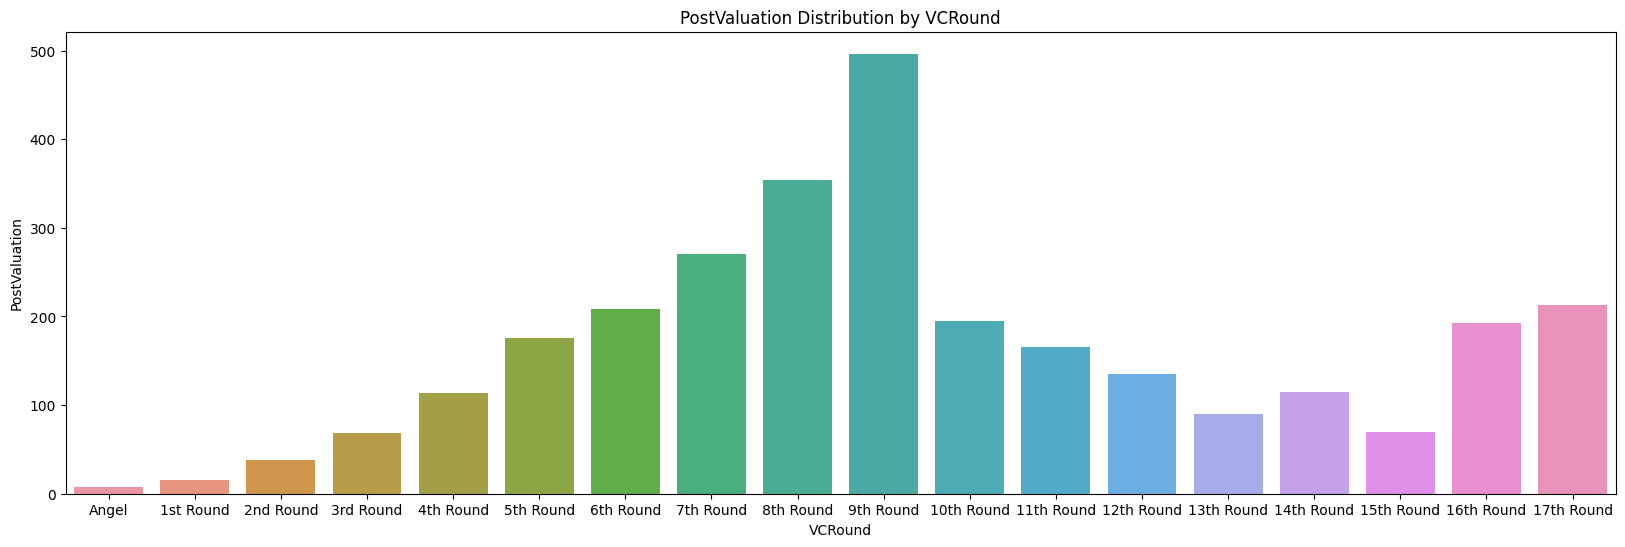

In [808]:
median_vc = deals_sorted.groupby('VCRound')['PostValuation'].median().reset_index()
vc_order = ['Angel'] +[f'{i}st Round' for i in range(1, 2)]+[f'{i}nd Round' for i in range(2, 3)] +[f'{i}rd Round' for i in range(3, 4)] +[f'{i}th Round' for i in range(4, 18)]
plt.figure(figsize=(20, 6))
sns.barplot(data = median_vc, x = 'VCRound', y = 'PostValuation', order=vc_order)
plt.title('PostValuation Distribution by VCRound')

# have reason to believe that as vc rounds increase, postval increases, until it plateaus and decreases as vc rounds increase (sus bc havent exit)

In [ ]:
# from eda, we can see that pattern goes from -> higher rounds -> higher vals -> plateaus and decreases
def encode_VCRounds(x):
     if pd.isnull(x):
        return -1
     elif x == 'Angel':
        return 0
     else:
         return int(x.split()[0].rstrip('stndrdth'))

df['VCRound'] = df['VCRound'].apply(encode_VCRounds)

From the bar chart, we observe that VCRound generally follows an expected pattern: as funding rounds increase, PostValuation tends to rise, eventually declining at the later rounds.

### AddOn

In [249]:
df['AddOn'].value_counts()

AddOn
No     30475
Yes      205
Name: count, dtype: int64

/Users/peiyuanlee/miniforge3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/peiyuanlee/miniforge3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'PostValuation Distribution by AddOn')

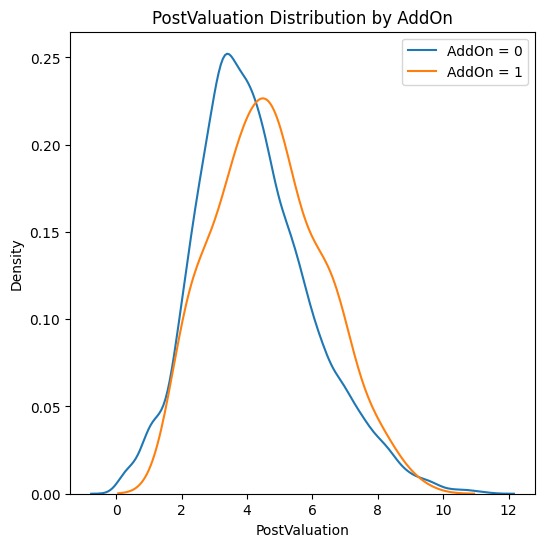

In [ ]:
plt.figure(figsize=(6, 6))
for category in [0, 1]:
        sns.kdeplot(
            data=df[df['AddOn'] == category],
            x=np.log1p(df.loc[df['AddOn'] == category, 'PostValuation']),
            label=f'{"AddOn"} = {category}'
        )
plt.legend()
plt.title('PostValuation Distribution by AddOn')

In [553]:
df['AddOn'] = df['AddOn'].apply(lambda x: x == 'Yes')

In [454]:
from scipy.stats import ttest_ind

addon_0 = df[df['AddOn'] == 0]['PostValuation'].dropna()
addon_1 = df[df['AddOn'] == 1]['PostValuation'].dropna()

t_stat, p = ttest_ind(addon_0, addon_1, equal_var=False)
print(f"T-test p-value: {p:.4f}")


T-test p-value: 0.2798


AddOn does not seem to be significantly associated with PostValuations, as there are no meaningful difference in Valuations with AddOn and no AddOn.

### Business Status

In [252]:
df['BusinessStatus_x'].value_counts()

BusinessStatus_x
Generating Revenue                   21484
Startup                               3672
Profitable                            2446
Generating Revenue/Not Profitable      627
Pre-Clinical Trials                    456
Clinical Trials - Phase 2              359
Clinical Trials - Phase 1              353
Clinical Trials - General              300
Product Development                    278
Stealth                                156
Product In Beta Test                   142
Clinical Trials - Phase 3              137
Bankruptcy: Admin/Reorg                112
Restart                                  8
Bankruptcy: Liquidation                  7
Out of Business                          4
Clinical Trials - Phase 4                1
Name: count, dtype: int64

In [195]:
df[df['BusinessStatus_x'] == 'Restart'][['PostValuation', 'BusinessStatus_y', 'Employees_x', 'CompanyID']]

PostValuation    BusinessStatus_y  Employees_x  CompanyID
27444            NaN          Profitable          NaN   13237-39
27313            NaN          Profitable          NaN   13237-39
26945            NaN          Profitable          NaN   13237-39
26412            NaN          Profitable          NaN   13237-39
25875            NaN          Profitable          NaN   13237-39
18528            NaN  Generating Revenue          NaN  267553-81
7296             NaN             Restart         15.0  438009-22
5087             NaN  Generating Revenue          NaN   54698-50

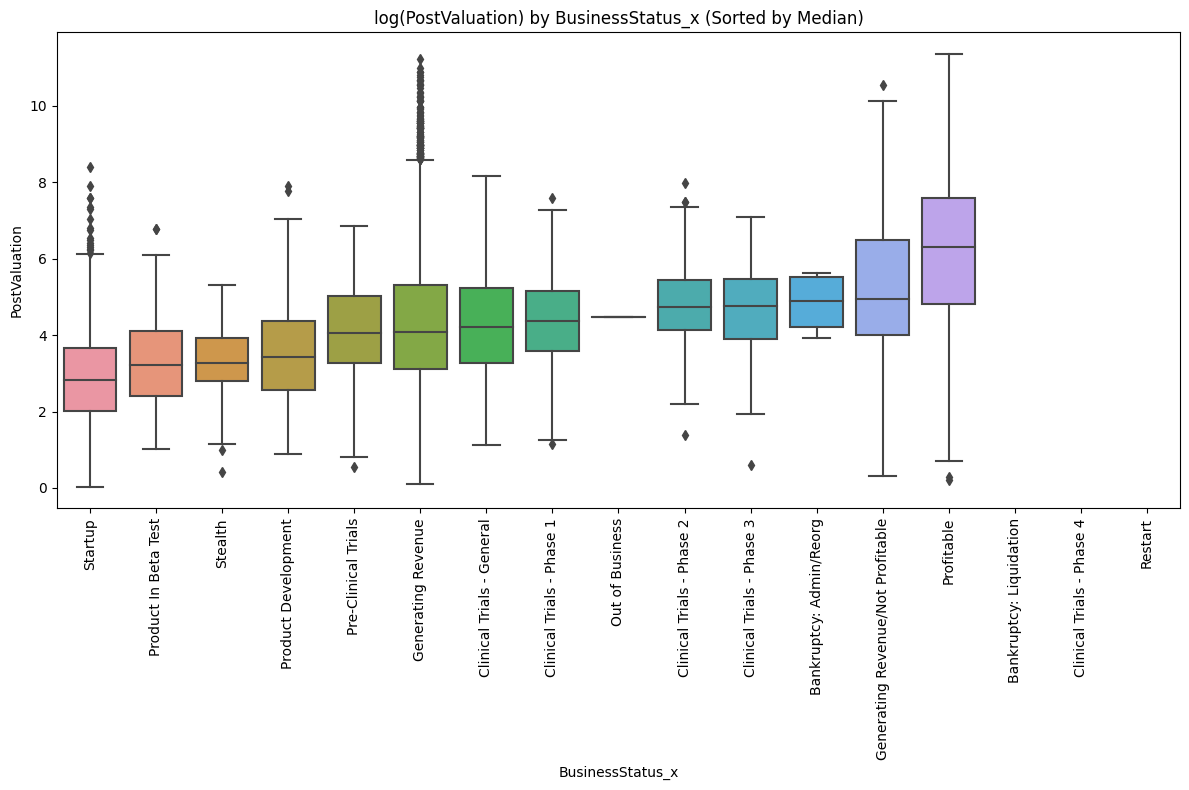

In [642]:
median_order = df.groupby('BusinessStatus_x')['PostValuation'].median().sort_values().index

plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='BusinessStatus_x', y=np.log1p(df['PostValuation']), order=median_order)
plt.title("log(PostValuation) by BusinessStatus_x (Sorted by Median)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [456]:
df[df['BusinessStatus_x'] == 'Out of Business']['PostValuation'].notna().mean()

0.25

In [457]:
df[df['BusinessStatus_x'] == 'Bankruptcy: Admin/Reorg']['PostValuation'].notna().mean()

0.05357142857142857

BusinessStatus can be grouped into several broader categories: early-stage (e.g., 'Startup', 'Product Development'), mid-stage (e.g., 'Generating Revenue', 'Generating Revenue/Not Profitable'), clinical trial phases, late-stage (e.g., 'Profitable'), and failure-related statuses (e.g., 'Bankruptcy', 'Out of Business', 'Restart'). These groupings follow a logical progression, where earlier business stages tend to have lower post-valuations, and later-stage companies generally exhibit higher post-valuations.

However, from inspecting the data, entries with a business status of 'Bankruptcy', 'Restart' or 'Out of Business' have many missing PostValuations values. I imputed these entries with 0 or -1 since I'm assuming valuations are negatively impacted by these events.

In [784]:
def business_status_bins(x):
    if x in ['Startup', 'Stealth', 'Product In Beta Test', 'Product Development', 'Product In Beta Test', 'Pre-Clinical Trials']:
        return 1
    elif x in ['Clinical Trials - Phase 1', 'Clinical Trials - Phase 2', 'Clinical Trials - Phase 3', 'Clinical Trials - Phase 4']:
        return 2
    elif x in ['Restart', 'Bankruptcy: Admin/Reorg']:
        return 0
    elif x in ['Generating Revenue', 'Generating Revenue/Not Profitable']:
        return 3
    elif x in ['Profitable']:
        return 4
    elif x in ['Out of Business', 'Bankruptcy: Liquidation']:
        return -1
    else:
        return np.nan


df['BusinessStatus_x_ordinal'] = df['BusinessStatus_x'].map(business_status_bins)

### Financing Status

In [790]:
df['FinancingStatus'].value_counts()

FinancingStatus
Venture Capital-Backed                   17927
Private Equity-Backed                     3707
Corporation                               2454
Formerly VC-backed                        1340
Accelerator/Incubator Backed              1265
Corporate Backed or Acquired              1115
Formerly PE-Backed                         765
Angel-Backed                               645
Private Debt Financed                      334
Pending Transaction (M&A)                  311
Pending Transaction (VC)                   225
Failed Transaction (M&A)                   172
Failed Transaction (VC)                    106
Pending Transaction (PE)                    80
Failed Transaction (PE)                     56
Formerly Angel backed                       55
Failed Transaction (Angel)                  36
Pending Transaction (Angel)                 14
Formerly Accelerator/Incubator backed       12
Formerly Private Debt Financed               8
Pending Transaction (Debt)                  

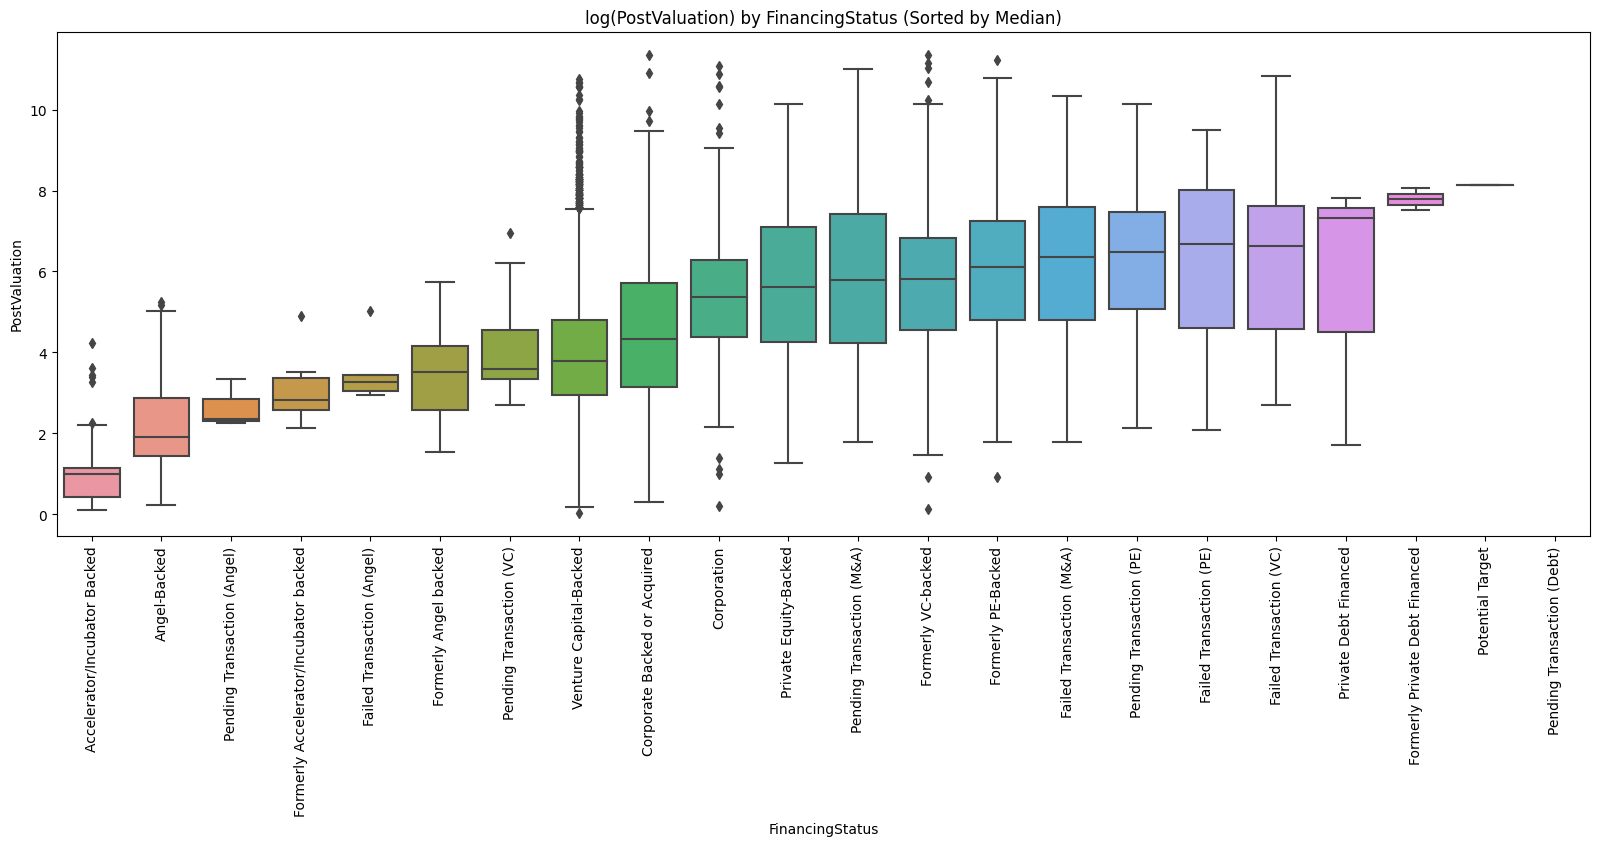

In [744]:
median_order = df.groupby('FinancingStatus')['PostValuation'].median().sort_values().index

plt.figure(figsize=(17, 6))
sns.boxplot(data=df, x='FinancingStatus', y=np.log1p(df['PostValuation']), order=median_order)
plt.title("log(PostValuation) by FinancingStatus (Sorted by Median)")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [792]:
df['FinancingStatus'].isna().sum()

48

### Company Financing Status

In [789]:
df['CompanyFinancingStatus'].value_counts()

CompanyFinancingStatus
Venture Capital-Backed                   18129
Private Equity-Backed                     4303
Formerly VC-backed                        3509
Formerly PE-Backed                        1767
Corporate Backed or Acquired              1305
Corporation                               1206
Pending Transaction (M&A)                  165
Pending Transaction (PE)                    84
Private Debt Financed                       58
Formerly Angel backed                       54
Pending Transaction (VC)                    34
Failed Transaction (M&A)                    17
Angel-Backed                                14
Formerly Accelerator/Incubator backed       13
Formerly Private Debt Financed              10
Accelerator/Incubator Backed                 9
Failed Transaction (VC)                      3
Name: count, dtype: int64

In [791]:
df['CompanyFinancingStatus'].isna().sum()

0

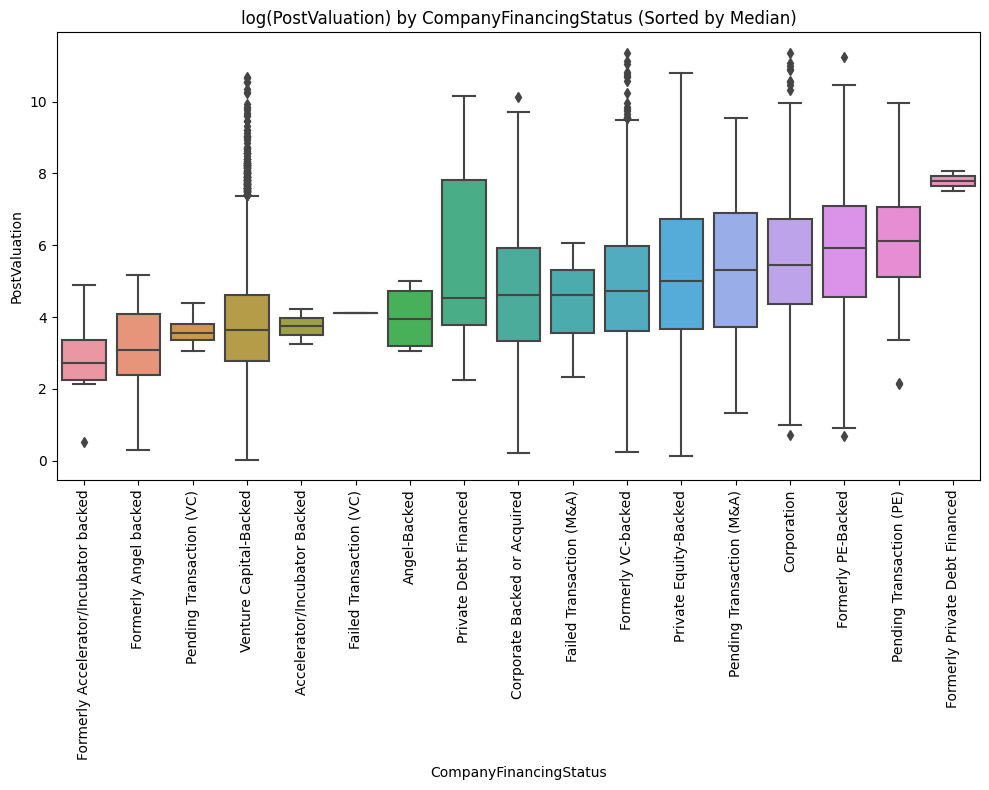

In [788]:
median_order = df.groupby('CompanyFinancingStatus')['PostValuation'].median().sort_values().index

plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='CompanyFinancingStatus', y=np.log1p(df['PostValuation']), order=median_order)
plt.title("log(PostValuation) by CompanyFinancingStatus (Sorted by Median)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# one hot encoding
lb = LabelBinarizer()
lb.fit_transform(df['FinancingStatus'].fillna('NA'))
lb.classes_
encode_FinancingStatus = pd.DataFrame(lb.fit_transform(df['CompanyFinancingStatus'].fillna('NA')),
    columns=[f'FinancingStatus_{label}' for label in lb.classes_],
    index= df.index
)

df = pd.concat([df, encode_FinancingStatus], axis=1)

Since CompanyFinancingStatus and FinancingStatus provide the same information, we use CompanyFinancingStatus as a feature since there are no missing values.

### Ownership Status

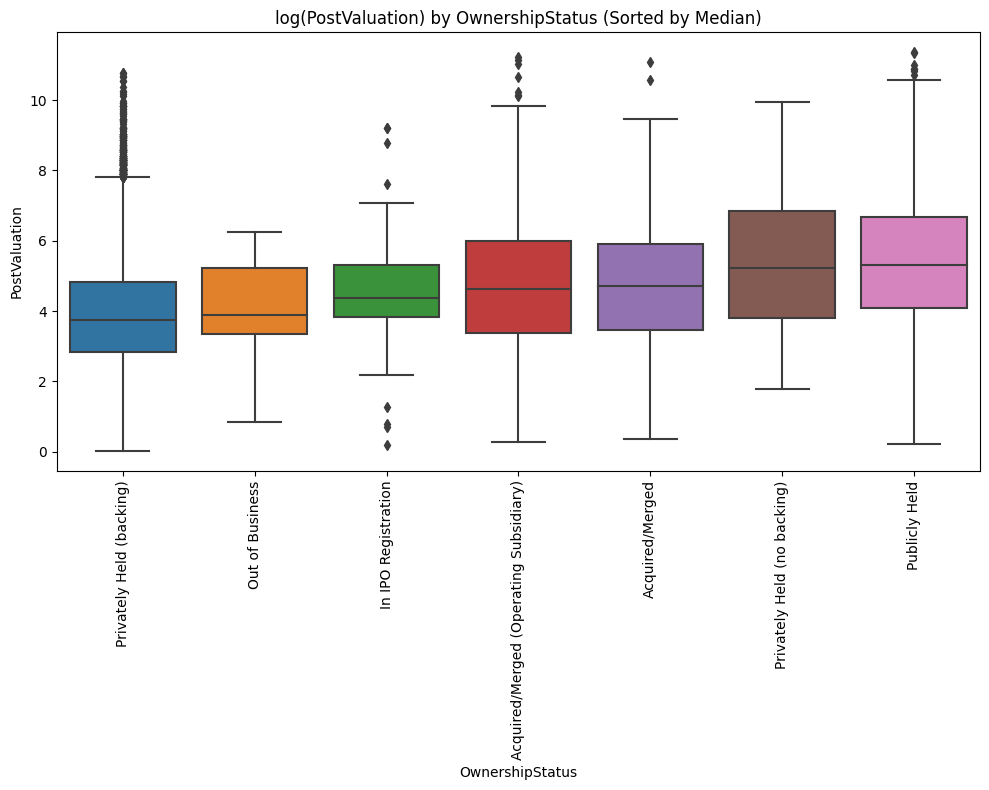

In [757]:
median_order = df.groupby('OwnershipStatus')['PostValuation'].median().sort_values().index

plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='OwnershipStatus', y=np.log1p(df['PostValuation']), order=median_order)
plt.title("log(PostValuation) by OwnershipStatus (Sorted by Median)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [471]:
df['OwnershipStatus'].value_counts()

OwnershipStatus
Privately Held (backing)                  21571
Publicly Held                              4584
Acquired/Merged (Operating Subsidiary)     3105
Acquired/Merged                             967
In IPO Registration                         203
Privately Held (no backing)                 202
Out of Business                              48
Name: count, dtype: int64

In [559]:
# one hot encoding
lb = LabelBinarizer()
lb.fit_transform(df['OwnershipStatus'].fillna('NA'))
lb.classes_
encode_OwnershipStatus = pd.DataFrame(lb.fit_transform(df['OwnershipStatus'].fillna('NA')),
    columns=[f'OwnershipStatus_{label}' for label in lb.classes_],
    index= df.index
)

df = pd.concat([df, encode_OwnershipStatus], axis=1)

### ParentCompany

In [560]:
df['is_ParentCompany']= df['ParentCompany'].notna()
df['is_ParentCompany'].value_counts()

is_ParentCompany
False    27126
True      3554
Name: count, dtype: int64

In [ ]:
features = encode_Universe.columns.tolist()

n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    for category in [0, 1]:
        sns.kdeplot(
            data=df[df[feature] == category],
            x=np.log1p(df.loc[df[feature] == category, 'PostValuation']),
            label=f'{feature} = {category}',
            ax=ax
        )
    ax.set_title(f'Distribution by {feature}')
    ax.grid(True, alpha=0.3)
    ax.legend()

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


/Users/peiyuanlee/miniforge3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/peiyuanlee/miniforge3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'PostValuation Distribution by is_ParentCompany')

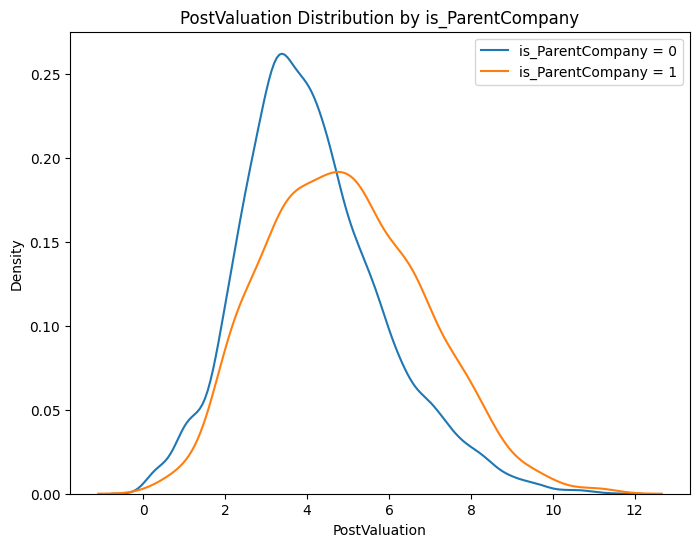

In [799]:
plt.figure(figsize=(8, 6))
# sns.boxplot(data = df, x = 'is_ParentCompany', y = np.log1p(df['PostValuation']))
for category in [0, 1]:
        sns.kdeplot(
            data=df[df['is_ParentCompany'] == category],
            x=np.log1p(df.loc[df['is_ParentCompany'] == category, 'PostValuation']),
            label=f'{"is_ParentCompany"} = {category}'
        )
plt.legend()
plt.title('PostValuation Distribution by is_ParentCompany')

In [785]:
pc_0 = df[df['is_ParentCompany'] == 0]['PostValuation'].dropna()
pc_1 = df[df['is_ParentCompany'] == 1]['PostValuation'].dropna()

t_stat, p = ttest_ind(pc_0, pc_1, equal_var=False)
print(f"T-test p-value: {p}")


T-test p-value: 1.6173060943261228e-06


is_ParentCompany is associated with PostValuations, as there is a statistically significant difference in distribution between Valuations with companies with and without parent companies, suggesting that they may be good predictors.

In [813]:
20 %10

0

In [818]:
nums = [1,1,2]
set(nums)

{1, 2}

In [819]:
len(set(nums))

2